# FTIR Textile Classification using Machine Learning

## Objective
Implement a hierarchical classification system for textile fibers using ATR-FTIR spectroscopy:
1. **Level 1**: Binary classification (Natural vs Synthetic fibers)
2. **Level 2**: Multi-class sub-classification within each main category

## Methodology
- **Preprocessing**: Polynomial baseline correction + SNV normalization (top-ranked pipeline)
- **Dimensionality Reduction**: Principal Component Analysis (PCA)
- **Classification Algorithm**: Support Vector Machine (SVM)
- **Validation**: Cross-validation with train-test split

## Dataset Structure
The raw spectral data will be organized with hierarchical labels:
- **Natural Fibers**: Cotton, Silk, Wool, Linen, Jute
- **Synthetic Fibers**: Polyester, Nylon, Acrylic, Modacrylic, Rayon

## Step 1: Import Required Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Preprocessing for spectroscopy
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Machine Learning - Dimensionality Reduction
from sklearn.decomposition import PCA

# Machine Learning - Classification
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

print("Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully
NumPy version: 2.2.6
Pandas version: 2.3.3


## Step 2: Define Preprocessing Functions

### Polynomial Baseline Correction
Polynomial baseline correction fits a polynomial function to the spectrum and subtracts it to remove baseline drift.

**Formula**: Fit polynomial $p(x)$ of degree $d$ to spectrum $y(x)$, then compute:
$$y_{corrected}(x) = y(x) - p(x)$$

**Reference**: Lieber, C.A. & Mahadevan-Jansen, A. (2003). Applied Spectroscopy

In [2]:
def polynomial_baseline_correction(y, x=None, degree=2):
    """
    Polynomial baseline correction for spectroscopy data.
    
    Fits a polynomial to the spectrum and subtracts it to remove baseline drift.
    This is simpler than ALS but effective for gentle baseline slopes.
    
    Parameters:
    -----------
    y : array-like
        Input spectrum intensities
    x : array-like, optional
        X-axis values (e.g., wavenumbers). If None, uses indices.
    degree : int, default=2
        Polynomial degree (1=linear, 2=quadratic, 3=cubic)
        Higher degrees can model curved baselines but risk overfitting
        
    Returns:
    --------
    corrected : ndarray
        Baseline-corrected spectrum
    baseline : ndarray
        Fitted polynomial baseline
    """
    if x is None:
        x = np.arange(len(y))
    
    # Fit polynomial using least squares
    coefficients = np.polyfit(x, y, degree)
    baseline = np.polyval(coefficients, x)
    
    # Subtract baseline from original spectrum
    corrected = y - baseline
    
    return corrected, baseline

### Standard Normal Variate (SNV)

SNV removes multiplicative scatter effects by standardizing each spectrum individually.

**Formula**:
$$\text{SNV}(x) = \frac{x - \bar{x}}{\sigma_x}$$

Where:
- $x$ = original spectrum
- $\bar{x}$ = mean of spectrum
- $\sigma_x$ = standard deviation of spectrum

**Effect**: Centers spectrum to mean=0 and scales to std=1, making spectra comparable while preserving chemical peak patterns.

**Reference**: Barnes, R.J., Dhanoa, M.S., Lister, S.J. (1989). Applied Spectroscopy

In [3]:
def standard_normal_variate(spectrum):
    """
    Standard Normal Variate (SNV) transformation.
    
    Removes multiplicative scatter effects by centering and scaling.
    Each spectrum is standardized to mean=0 and std=1.
    
    Parameters:
    -----------
    spectrum : array-like
        Input spectrum
    
    Returns:
    --------
    snv_spectrum : ndarray
        SNV-transformed spectrum
    """
    mean_val = np.mean(spectrum)
    std_val = np.std(spectrum)
    
    # Avoid division by zero for constant spectra
    if std_val == 0:
        return spectrum - mean_val
    
    snv_spectrum = (spectrum - mean_val) / std_val
    return snv_spectrum

### Complete Preprocessing Pipeline

Combines polynomial baseline correction and SNV normalization.

In [4]:
def preprocess_spectrum(transmittance, wavenumbers):
    """
    Complete preprocessing pipeline: %T -> Absorbance -> Baseline Correction -> SNV
    
    This follows the top-ranked pipeline from preprocessing analysis:
    Polynomial baseline correction (degree 2) + SNV normalization
    
    Parameters:
    -----------
    transmittance : array-like
        Percent transmittance values (%T)
    wavenumbers : array-like
        Wavenumber values (cm-1)
    
    Returns:
    --------
    processed : ndarray
        Fully preprocessed spectrum ready for ML
    """
    # Convert transmittance to absorbance
    # A = 2 - log10(T) where T is in percentage form
    # Add small epsilon to avoid log(0)
    absorbance = 2 - np.log10(transmittance + 1e-9)
    
    # Step 1: Polynomial baseline correction (degree 2)
    corrected, _ = polynomial_baseline_correction(absorbance, wavenumbers, degree=2)
    
    # Step 2: SNV normalization
    processed = standard_normal_variate(corrected)
    
    return processed

## Step 3: Load and Organize Dataset

### Fiber Classification Taxonomy

Based on fiber origin and chemical composition, textiles are classified as:

**Natural Fibers** (derived from plants or animals):
- **Plant-based**: Cotton, Linen, Jute
- **Animal-based**: Silk, Wool

**Synthetic Fibers** (man-made polymers):
- **Petroleum-based**: Polyester, Nylon, Acrylic, Modacrylic
- **Semi-synthetic**: Rayon (cellulose-derived but chemically processed)

Note: Rayon is classified as synthetic here due to its manufactured nature, though it originates from cellulose.

In [5]:
# Define fiber classification
FIBER_CLASSIFICATION = {
    # Natural fibers
    'Cotton': 'Natural',
    'Silk': 'Natural',
    'Wool': 'Natural',
    'Linen': 'Natural',
    'Jute': 'Natural',
    
    # Synthetic fibers
    'Polyester': 'Synthetic',
    'Nylon': 'Synthetic',
    'Acrylic': 'Synthetic',
    'Modacrylic': 'Synthetic',
    'Rayon': 'Synthetic'  # Semi-synthetic, but classified as synthetic
}

print("Fiber Classification:")
print("="*50)
print("\nNatural Fibers:")
for fiber, category in FIBER_CLASSIFICATION.items():
    if category == 'Natural':
        print(f"  - {fiber}")

print("\nSynthetic Fibers:")
for fiber, category in FIBER_CLASSIFICATION.items():
    if category == 'Synthetic':
        print(f"  - {fiber}")

Fiber Classification:

Natural Fibers:
  - Cotton
  - Silk
  - Wool
  - Linen
  - Jute

Synthetic Fibers:
  - Polyester
  - Nylon
  - Acrylic
  - Modacrylic
  - Rayon


In [6]:
# Load all CSV files from raw data folder
data_folder = Path('raw_csv_data')
csv_files = list(data_folder.glob("*.csv"))

print(f"Total CSV files found: {len(csv_files)}")

# Initialize lists to store data
all_spectra = []
fiber_types = []
fiber_categories = []
sample_names = []
wavenumbers_ref = None

# Process each file
print("\nProcessing spectral data...")
for csv_file in sorted(csv_files):
    # Extract fiber type from filename
    # Pattern: "FiberType - Number.csv" or "FiberType Number.csv"
    match = re.match(r"([a-zA-Z\s]+)", csv_file.stem)
    if match:
        fiber_type = match.group(1).strip()
    else:
        print(f"Warning: Could not parse fiber type from {csv_file.name}")
        continue
    
    # Skip if fiber type not in classification
    if fiber_type not in FIBER_CLASSIFICATION:
        print(f"Warning: Unknown fiber type '{fiber_type}' in file {csv_file.name}")
        continue
    
    try:
        # Read CSV file (skip header row)
        df = pd.read_csv(csv_file, skiprows=1, header=0)
        
        # Extract wavenumbers and transmittance
        wavenumbers = df['cm-1'].values
        transmittance = df['%T'].values
        
        # Store reference wavenumbers (should be same for all files)
        if wavenumbers_ref is None:
            wavenumbers_ref = wavenumbers
        
        # Preprocess spectrum
        processed_spectrum = preprocess_spectrum(transmittance, wavenumbers)
        
        # Store data
        all_spectra.append(processed_spectrum)
        fiber_types.append(fiber_type)
        fiber_categories.append(FIBER_CLASSIFICATION[fiber_type])
        sample_names.append(csv_file.stem)
        
    except Exception as e:
        print(f"Error processing {csv_file.name}: {str(e)}")

# Convert to numpy arrays
X_preprocessed = np.array(all_spectra)
y_fiber_type = np.array(fiber_types)
y_category = np.array(fiber_categories)

print(f"\nData loading complete!")
print(f"Total samples: {len(X_preprocessed)}")
print(f"Spectral features per sample: {X_preprocessed.shape[1]}")
print(f"Wavenumber range: {wavenumbers_ref[0]:.1f} - {wavenumbers_ref[-1]:.1f} cm⁻¹")

Total CSV files found: 62

Processing spectral data...

Data loading complete!
Total samples: 62
Spectral features per sample: 3451
Wavenumber range: 4000.0 - 550.0 cm⁻¹


In [7]:
# Create comprehensive dataset DataFrame
dataset_info = pd.DataFrame({
    'Sample_Name': sample_names,
    'Fiber_Type': fiber_types,
    'Category': fiber_categories
})

print("\nDataset Overview:")
print("="*70)
print(dataset_info.head(10))

# Display class distribution
print("\n" + "="*70)
print("Category Distribution (Natural vs Synthetic):")
print("="*70)
category_counts = dataset_info['Category'].value_counts()
for category, count in category_counts.items():
    percentage = (count / len(dataset_info)) * 100
    print(f"  {category:<12}: {count:>3} samples ({percentage:>5.1f}%)")

print("\n" + "="*70)
print("Fiber Type Distribution:")
print("="*70)
fiber_counts = dataset_info['Fiber_Type'].value_counts().sort_index()
for fiber, count in fiber_counts.items():
    category = FIBER_CLASSIFICATION[fiber]
    print(f"  {fiber:<15} ({category:<10}): {count:>2} samples")


Dataset Overview:
  Sample_Name Fiber_Type   Category
0   Acrylic 1    Acrylic  Synthetic
1   Acrylic 2    Acrylic  Synthetic
2   Acrylic 3    Acrylic  Synthetic
3   Acrylic 4    Acrylic  Synthetic
4   Acrylic 5    Acrylic  Synthetic
5  Cotton - 1     Cotton    Natural
6  Cotton - 2     Cotton    Natural
7  Cotton - 3     Cotton    Natural
8  Cotton - 4     Cotton    Natural
9  Cotton - 5     Cotton    Natural

Category Distribution (Natural vs Synthetic):
  Synthetic   :  33 samples ( 53.2%)
  Natural     :  29 samples ( 46.8%)

Fiber Type Distribution:
  Acrylic         (Synthetic ):  5 samples
  Cotton          (Natural   ):  6 samples
  Jute            (Natural   ):  2 samples
  Linen           (Natural   ):  6 samples
  Modacrylic      (Synthetic ):  4 samples
  Nylon           (Synthetic ):  3 samples
  Polyester       (Synthetic ):  9 samples
  Rayon           (Synthetic ): 12 samples
  Silk            (Natural   ): 11 samples
  Wool            (Natural   ):  4 samples


## Step 3.5: Preprocessing Pipeline Visualization

### Understanding the Complete Preprocessing Workflow

Before applying machine learning algorithms, we need to ensure all spectra are properly preprocessed. This section demonstrates the complete preprocessing pipeline step-by-step:

1. **Raw Transmittance Spectra**: Original data from ATR-FTIR instrument
2. **Absorbance Conversion**: Transform %T to absorbance units using Beer-Lambert law
3. **Polynomial Baseline Correction**: Remove systematic baseline drift
4. **SNV Normalization**: Standardize intensity variations across samples

**Purpose**: 
- Visualize how each preprocessing step affects the spectral data
- Verify that preprocessing effectively removes unwanted variations
- Ensure data quality before dimensionality reduction and classification

This comprehensive visualization allows us to:
- Identify any preprocessing artifacts or issues
- Confirm that chemical information is preserved
- Validate the effectiveness of baseline correction and normalization

In [8]:
# Select representative samples for visualization (one from each fiber type)
# This provides a comprehensive view of how preprocessing affects different materials

representative_samples = {}
for fiber in FIBER_CLASSIFICATION.keys():
    # Get the first sample of each fiber type
    fiber_mask = y_fiber_type == fiber
    if fiber_mask.any():
        idx = np.where(fiber_mask)[0][0]
        representative_samples[fiber] = idx

print("Selected Representative Samples for Preprocessing Visualization:")
print("="*70)
for fiber, idx in representative_samples.items():
    category = FIBER_CLASSIFICATION[fiber]
    sample_name = sample_names[idx]
    print(f"  {fiber:<15} ({category:<10}): {sample_name}")
    
print(f"\nTotal samples selected: {len(representative_samples)}")

Selected Representative Samples for Preprocessing Visualization:
  Cotton          (Natural   ): Cotton - 1
  Silk            (Natural   ): Silk - 1
  Wool            (Natural   ): Wool - 1
  Linen           (Natural   ): Linen - 1
  Jute            (Natural   ): Jute - 1
  Polyester       (Synthetic ): Polyester - 1
  Nylon           (Synthetic ): Nylon 1
  Acrylic         (Synthetic ): Acrylic 1
  Modacrylic      (Synthetic ): Modacrylic - 1
  Rayon           (Synthetic ): Rayon - 1

Total samples selected: 10


In [9]:
# Process each preprocessing step for visualization
# Store intermediate results to show the complete pipeline transformation

preprocessing_stages = {
    'raw_transmittance': [],
    'absorbance': [],
    'baseline_corrected': [],
    'snv_normalized': []
}

# Load raw data and apply each preprocessing step
data_folder = Path('raw_csv_data')

for fiber, idx in representative_samples.items():
    sample_name = sample_names[idx]
    
    # Find the corresponding CSV file
    csv_file = data_folder / f"{sample_name}.csv"
    
    # Read raw data
    df = pd.read_csv(csv_file, skiprows=1, header=0)
    wavenumbers = df['cm-1'].values
    transmittance = df['%T'].values
    
    # Stage 1: Raw transmittance
    preprocessing_stages['raw_transmittance'].append({
        'fiber': fiber,
        'data': transmittance,
        'wavenumbers': wavenumbers
    })
    
    # Stage 2: Convert to absorbance
    # A = 2 - log10(%T) where %T is in percentage form
    absorbance = 2 - np.log10(transmittance + 1e-9)
    preprocessing_stages['absorbance'].append({
        'fiber': fiber,
        'data': absorbance,
        'wavenumbers': wavenumbers
    })
    
    # Stage 3: Polynomial baseline correction
    corrected, baseline = polynomial_baseline_correction(absorbance, wavenumbers, degree=2)
    preprocessing_stages['baseline_corrected'].append({
        'fiber': fiber,
        'data': corrected,
        'baseline': baseline,
        'wavenumbers': wavenumbers
    })
    
    # Stage 4: SNV normalization
    snv_spectrum = standard_normal_variate(corrected)
    preprocessing_stages['snv_normalized'].append({
        'fiber': fiber,
        'data': snv_spectrum,
        'wavenumbers': wavenumbers
    })

print("Preprocessing pipeline applied to all representative samples")
print(f"Stages captured: {list(preprocessing_stages.keys())}")

Preprocessing pipeline applied to all representative samples
Stages captured: ['raw_transmittance', 'absorbance', 'baseline_corrected', 'snv_normalized']


### Visualization 1: Single Sample Pipeline Transformation

Demonstrate the complete preprocessing pipeline on a single representative sample to clearly show each transformation step.

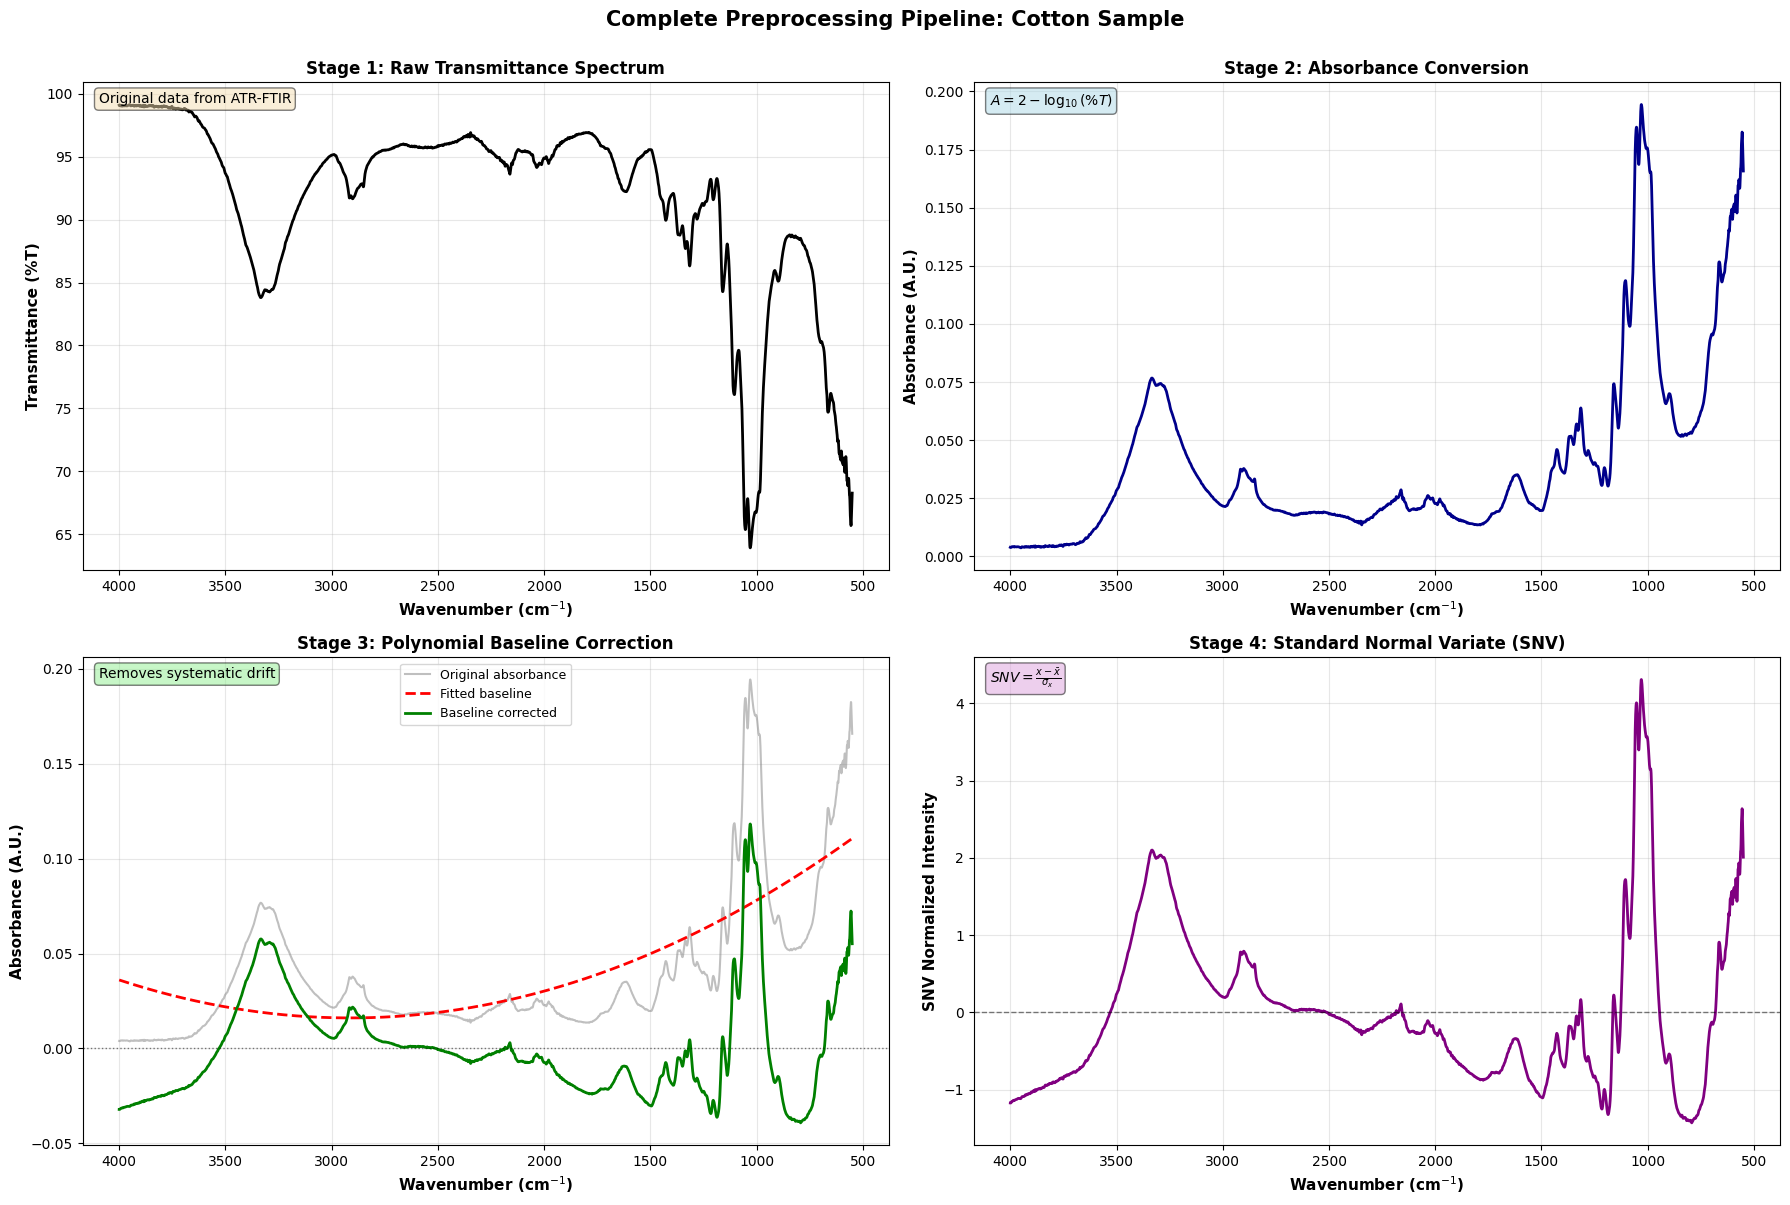


Preprocessing pipeline visualization complete for Cotton

Key observations:
  Stage 1: Raw transmittance shows characteristic peaks and baseline
  Stage 2: Absorbance conversion inverts peaks (higher absorption = higher values)
  Stage 3: Baseline correction removes drift, centering spectrum near zero
  Stage 4: SNV normalization standardizes intensity scale (mean=0, std=1)


In [27]:
# Select one sample to demonstrate the complete pipeline (e.g., Cotton)
demo_fiber = 'Cotton'
demo_idx = 0

# Create a 2x2 subplot showing each preprocessing stage
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

# Stage 1: Raw Transmittance
stage1 = preprocessing_stages['raw_transmittance'][demo_idx]
axes[0].plot(stage1['wavenumbers'], stage1['data'], linewidth=2, color='black')
axes[0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Transmittance (%T)', fontsize=11, fontweight='bold')
axes[0].set_title('Stage 1: Raw Transmittance Spectrum', fontsize=12, fontweight='bold')
axes[0].invert_xaxis()
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.98, 'Original data from ATR-FTIR', 
            transform=axes[0].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Stage 2: Absorbance
stage2 = preprocessing_stages['absorbance'][demo_idx]
axes[1].plot(stage2['wavenumbers'], stage2['data'], linewidth=2, color='darkblue')
axes[1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Absorbance (A.U.)', fontsize=11, fontweight='bold')
axes[1].set_title('Stage 2: Absorbance Conversion', fontsize=12, fontweight='bold')
axes[1].invert_xaxis()
axes[1].grid(True, alpha=0.3)
axes[1].text(0.02, 0.98, r'$A = 2 - \log_{10}(\%T)$', 
            transform=axes[1].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Stage 3: Baseline Correction
stage3 = preprocessing_stages['baseline_corrected'][demo_idx]
axes[2].plot(stage3['wavenumbers'], stage3['data'] + stage3['baseline'], 
            linewidth=1.5, color='gray', alpha=0.5, label='Original absorbance')
axes[2].plot(stage3['wavenumbers'], stage3['baseline'], 
            linewidth=2, color='red', linestyle='--', label='Fitted baseline')
axes[2].plot(stage3['wavenumbers'], stage3['data'], 
            linewidth=2, color='green', label='Baseline corrected')
axes[2].axhline(y=0, color='k', linestyle=':', linewidth=1, alpha=0.5)
axes[2].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Absorbance (A.U.)', fontsize=11, fontweight='bold')
axes[2].set_title('Stage 3: Polynomial Baseline Correction', fontsize=12, fontweight='bold')
axes[2].invert_xaxis()
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='best', fontsize=9)
axes[2].text(0.02, 0.98, 'Removes systematic drift', 
            transform=axes[2].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Stage 4: SNV Normalization
stage4 = preprocessing_stages['snv_normalized'][demo_idx]
axes[3].plot(stage4['wavenumbers'], stage4['data'], linewidth=2, color='purple')
axes[3].axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
axes[3].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[3].set_ylabel('SNV Normalized Intensity', fontsize=11, fontweight='bold')
axes[3].set_title('Stage 4: Standard Normal Variate (SNV)', fontsize=12, fontweight='bold')
axes[3].invert_xaxis()
axes[3].grid(True, alpha=0.3)
axes[3].text(0.02, 0.98, r'$SNV = \frac{x - \bar{x}}{\sigma_x}$', 
            transform=axes[3].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='plum', alpha=0.5))

plt.suptitle(f'Complete Preprocessing Pipeline: {demo_fiber} Sample', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\nPreprocessing pipeline visualization complete for {demo_fiber}")
print("="*70)
print("\nKey observations:")
print("  Stage 1: Raw transmittance shows characteristic peaks and baseline")
print("  Stage 2: Absorbance conversion inverts peaks (higher absorption = higher values)")
print("  Stage 3: Baseline correction removes drift, centering spectrum near zero")
print("  Stage 4: SNV normalization standardizes intensity scale (mean=0, std=1)")

### Visualization 2: All Fiber Types at Each Processing Stage

Compare how different fiber types appear at each stage of the preprocessing pipeline. This helps identify:
- Stage-specific patterns across fiber categories
- Effectiveness of each preprocessing step
- Spectral diversity within Natural and Synthetic groups

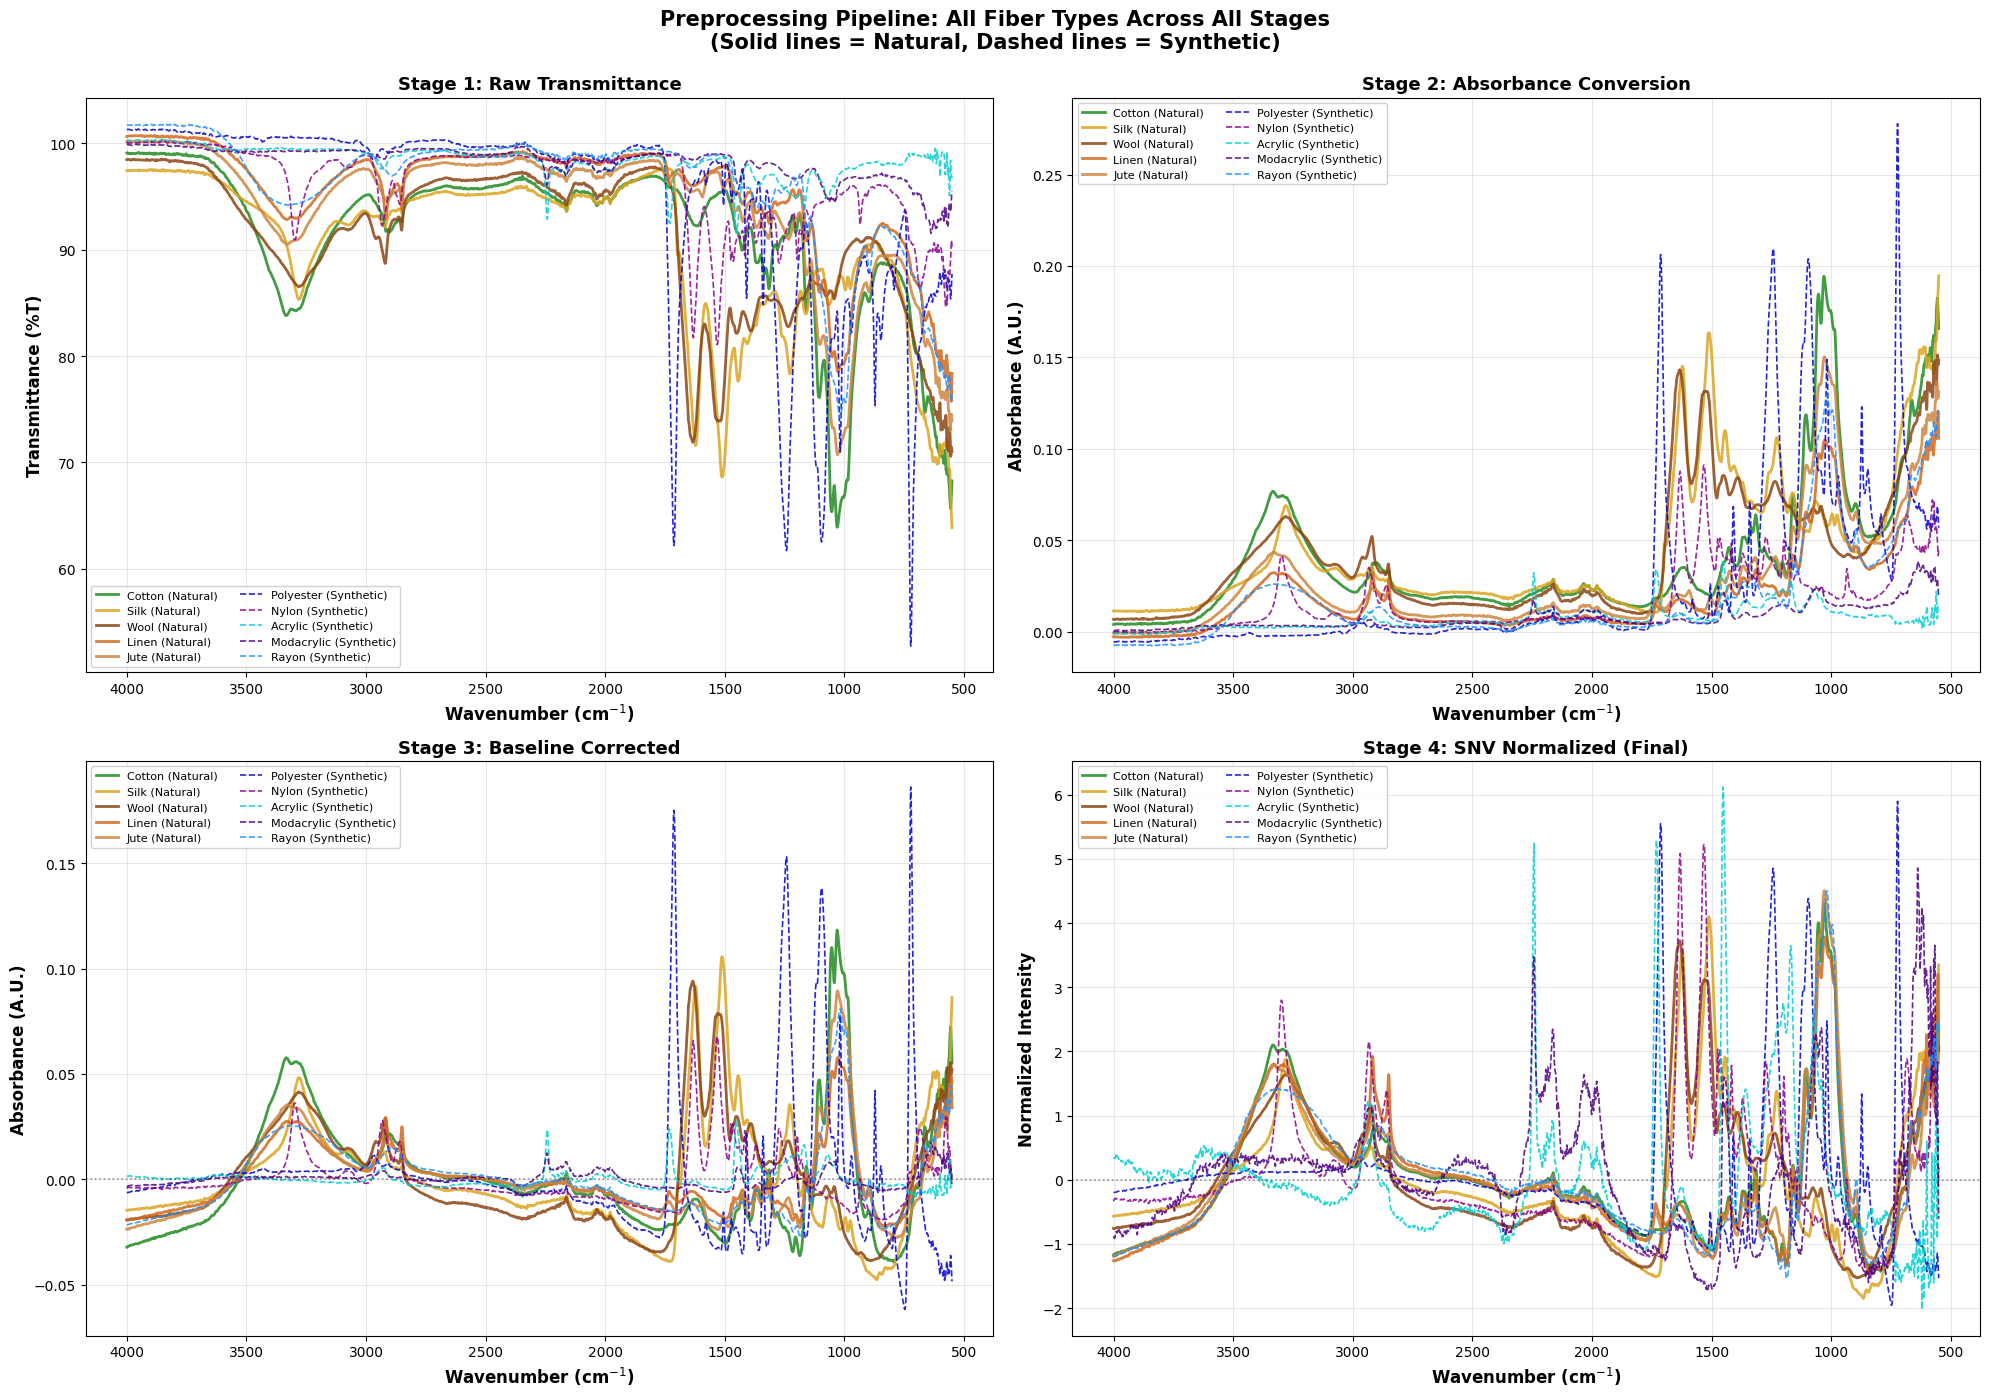

Comprehensive preprocessing visualization complete

Visualization shows:
  - All 10 fiber types processed through 4 stages
  - Natural fibers shown with solid lines
  - Synthetic fibers shown with dashed lines
  - Progressive transformation from raw data to ML-ready features


In [36]:
# Create a comprehensive visualization showing all fiber types at each stage
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

# Define colors for each fiber type with clear Natural vs Synthetic distinction
# Natural fibers: Warm, earthy, saturated tones (browns, greens, warm reds)
# Synthetic fibers: Cool, modern, saturated tones (blues, purples, cyans)
fiber_colors = {
    # Natural fibers - warm and earthy tones
    'Cotton': '#228B22',    # Forest Green - strong, natural
    'Silk': '#DAA520',      # Goldenrod - luxurious, warm yellow
    'Wool': '#8B4513',      # Saddle Brown - earthy, warm
    'Linen': '#D2691E',     # Chocolate - warm orange-brown
    'Jute': '#CD853F',      # Peru - tan/brown, natural fiber
    
    # Synthetic fibers - cool and modern tones
    'Polyester': '#0000CD',  # Medium Blue - strong, synthetic
    'Nylon': '#8B008B',      # Dark Magenta - vibrant purple
    'Acrylic': '#00CED1',    # Dark Turquoise - bright cyan
    'Modacrylic': '#4B0082', # Indigo - deep purple-blue
    'Rayon': '#1E90FF'       # Dodger Blue - bright modern blue
}

stage_titles = [
    'Stage 1: Raw Transmittance',
    'Stage 2: Absorbance Conversion',
    'Stage 3: Baseline Corrected',
    'Stage 4: SNV Normalized (Final)'
]

stage_ylabels = [
    'Transmittance (%T)',
    'Absorbance (A.U.)',
    'Absorbance (A.U.)',
    'Normalized Intensity'
]

stage_keys = ['raw_transmittance', 'absorbance', 'baseline_corrected', 'snv_normalized']

# Plot each preprocessing stage
for idx, (stage_key, title, ylabel) in enumerate(zip(stage_keys, stage_titles, stage_ylabels)):
    ax = axes[idx]
    
    # Plot all fiber samples for this stage
    for sample in preprocessing_stages[stage_key]:
        fiber = sample['fiber']
        category = FIBER_CLASSIFICATION[fiber]
        linestyle = '-' if category == 'Natural' else '--'
        linewidth = 2.0 if category == 'Natural' else 1.2
        
        ax.plot(sample['wavenumbers'], sample['data'], 
               linewidth=linewidth, alpha=0.85, color=fiber_colors[fiber],
               linestyle=linestyle, label=f"{fiber} ({category})")
    
    # Add reference line at y=0 for stages 3 and 4
    if idx >= 2:
        ax.axhline(y=0, color='black', linestyle=':', linewidth=linewidth, alpha=0.4)
    
    ax.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.invert_xaxis()
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8, ncol=2, framealpha=0.9)

plt.suptitle('Preprocessing Pipeline: All Fiber Types Across All Stages\n(Solid lines = Natural, Dashed lines = Synthetic)', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Comprehensive preprocessing visualization complete")
print("="*70)
print("\nVisualization shows:")
print("  - All 10 fiber types processed through 4 stages")
print("  - Natural fibers shown with solid lines")
print("  - Synthetic fibers shown with dashed lines")
print("  - Progressive transformation from raw data to ML-ready features")

### Visualization 3: Natural vs Synthetic Comparison at Each Stage

Side-by-side comparison of Natural and Synthetic fiber groups through the preprocessing pipeline.

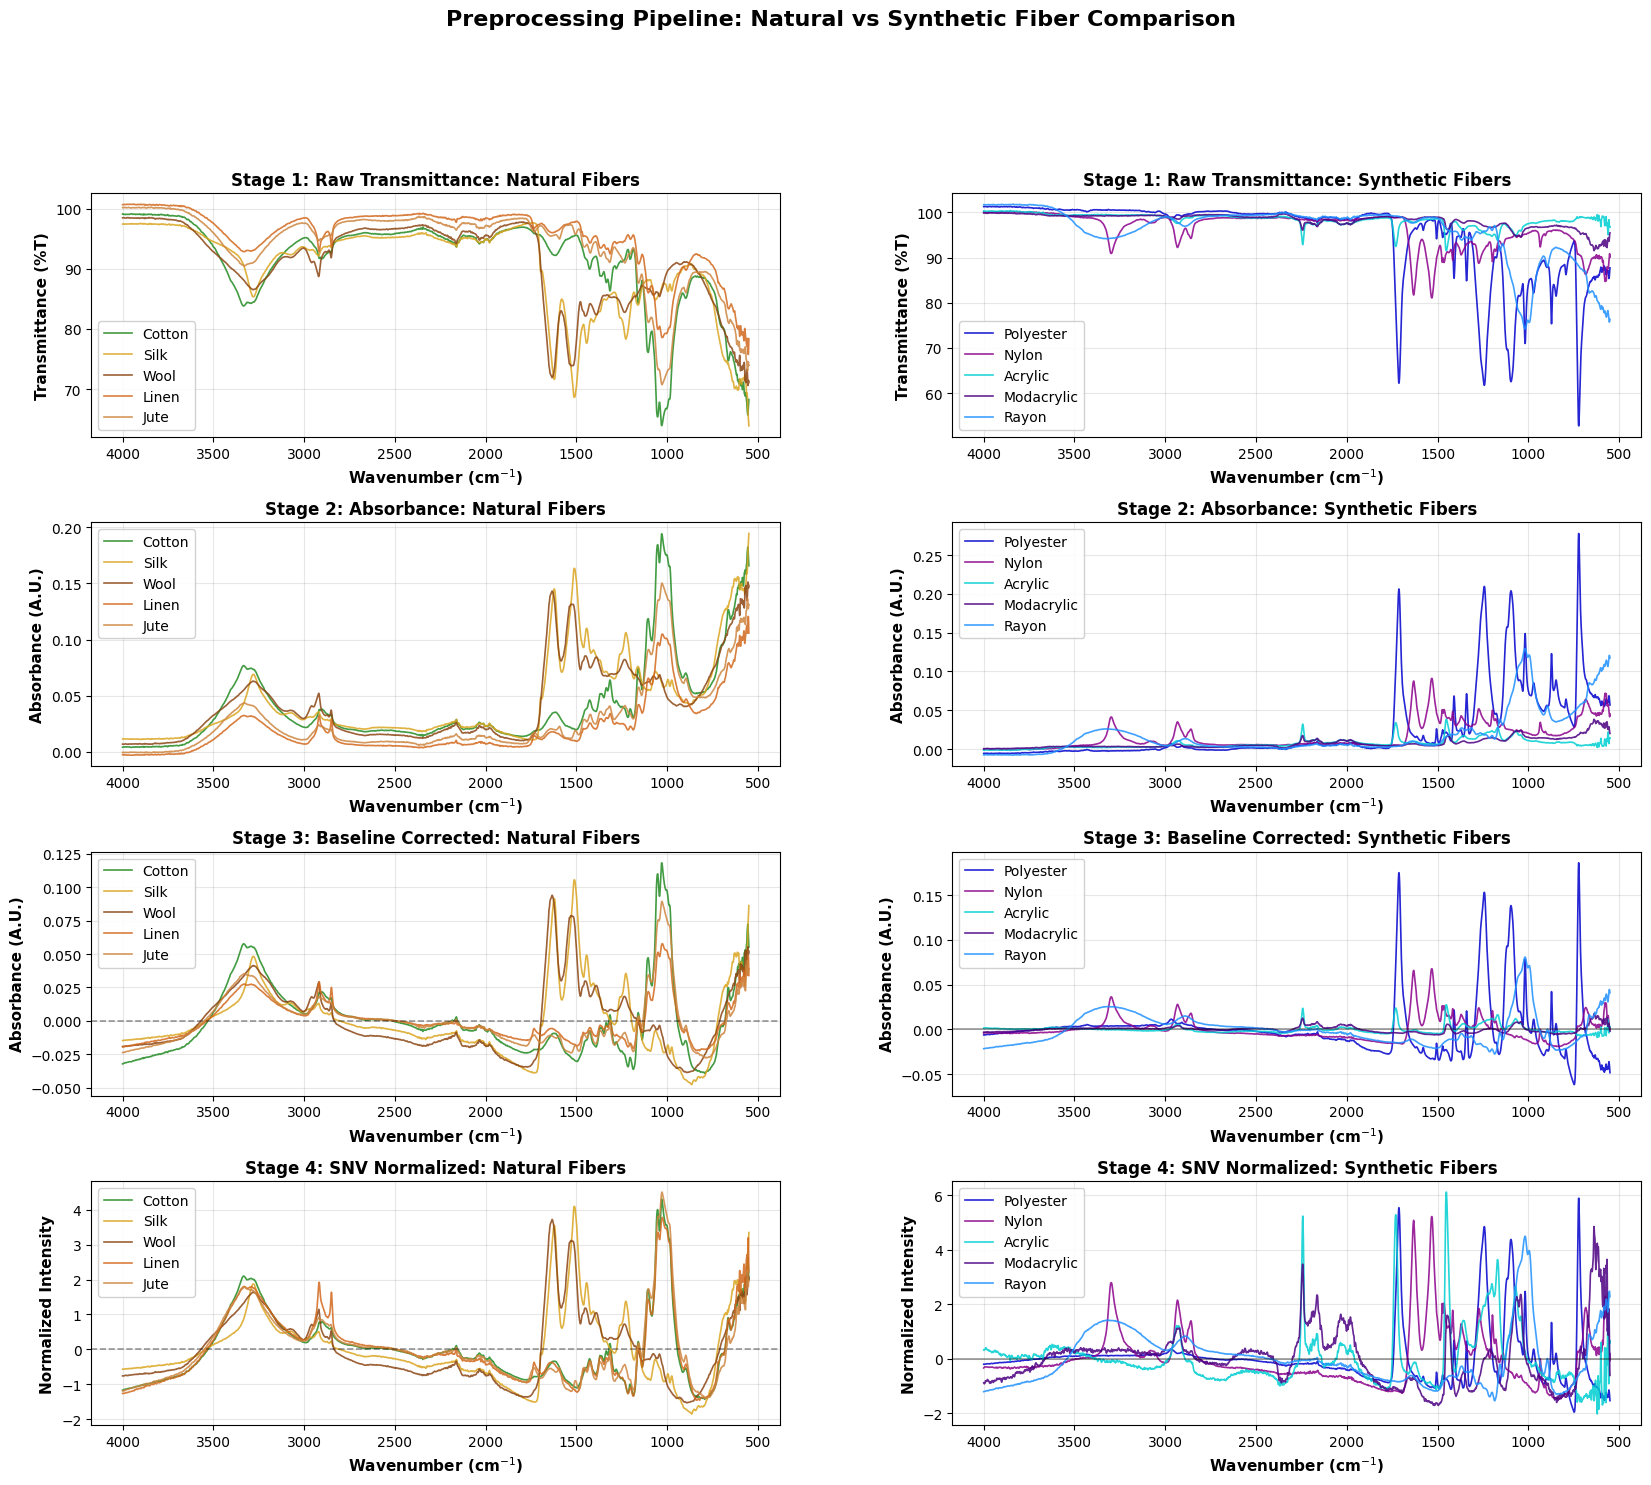

Natural vs Synthetic preprocessing comparison complete

Key insights:
  - Natural fibers: Cotton, Silk, Wool, Linen, Jute
  - Synthetic fibers: Polyester, Nylon, Acrylic, Modacrylic, Rayon
  - Each row shows one preprocessing stage
  - Left column: Natural fibers | Right column: Synthetic fibers
  - Observe how preprocessing affects inter-group and intra-group variation


In [34]:
# Create side-by-side comparison of Natural vs Synthetic at each stage
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(4, 2, figure=fig, hspace=0.35, wspace=0.25)

stages_info = [
    ('raw_transmittance', 'Stage 1: Raw Transmittance', 'Transmittance (%T)'),
    ('absorbance', 'Stage 2: Absorbance', 'Absorbance (A.U.)'),
    ('baseline_corrected', 'Stage 3: Baseline Corrected', 'Absorbance (A.U.)'),
    ('snv_normalized', 'Stage 4: SNV Normalized', 'Normalized Intensity')
]

for row, (stage_key, stage_title, ylabel) in enumerate(stages_info):
    # Natural fibers (left column)
    ax_natural = fig.add_subplot(gs[row, 0])
    for sample in preprocessing_stages[stage_key]:
        fiber = sample['fiber']
        if FIBER_CLASSIFICATION[fiber] == 'Natural':
            ax_natural.plot(sample['wavenumbers'], sample['data'],
                          linewidth=1.2, alpha=0.85, color=fiber_colors[fiber], label=fiber)
    
    if row >= 2:  # Add zero line for baseline corrected and SNV
        ax_natural.axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.4)
    
    ax_natural.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
    ax_natural.set_ylabel(ylabel, fontsize=11, fontweight='bold')
    ax_natural.set_title(f'{stage_title}: Natural Fibers', fontsize=12, fontweight='bold')
    ax_natural.invert_xaxis()
    ax_natural.grid(True, alpha=0.3)
    ax_natural.legend(loc='best', fontsize=10, framealpha=0.9)
    
    # Synthetic fibers (right column)
    ax_synthetic = fig.add_subplot(gs[row, 1])
    for sample in preprocessing_stages[stage_key]:
        fiber = sample['fiber']
        if FIBER_CLASSIFICATION[fiber] == 'Synthetic':
            ax_synthetic.plot(sample['wavenumbers'], sample['data'],
                            linewidth=1.2, alpha=0.85, color=fiber_colors[fiber], 
                            label=fiber)
    
    if row >= 2:  # Add zero line for baseline corrected and SNV
        ax_synthetic.axhline(y=0, color='black', linewidth=1.2, alpha=0.4)

    ax_synthetic.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
    ax_synthetic.set_ylabel(ylabel, fontsize=11, fontweight='bold')
    ax_synthetic.set_title(f'{stage_title}: Synthetic Fibers', fontsize=12, fontweight='bold')
    ax_synthetic.invert_xaxis()
    ax_synthetic.grid(True, alpha=0.3)
    ax_synthetic.legend(loc='best', fontsize=10, framealpha=0.9)

plt.suptitle('Preprocessing Pipeline: Natural vs Synthetic Fiber Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("Natural vs Synthetic preprocessing comparison complete")
print("="*70)
print("\nKey insights:")
print("  - Natural fibers: Cotton, Silk, Wool, Linen, Jute")
print("  - Synthetic fibers: Polyester, Nylon, Acrylic, Modacrylic, Rayon")
print("  - Each row shows one preprocessing stage")
print("  - Left column: Natural fibers | Right column: Synthetic fibers")
print("  - Observe how preprocessing affects inter-group and intra-group variation")

### Visualization 4: Before and After Preprocessing

Direct comparison showing the impact of the complete preprocessing pipeline on all spectra.

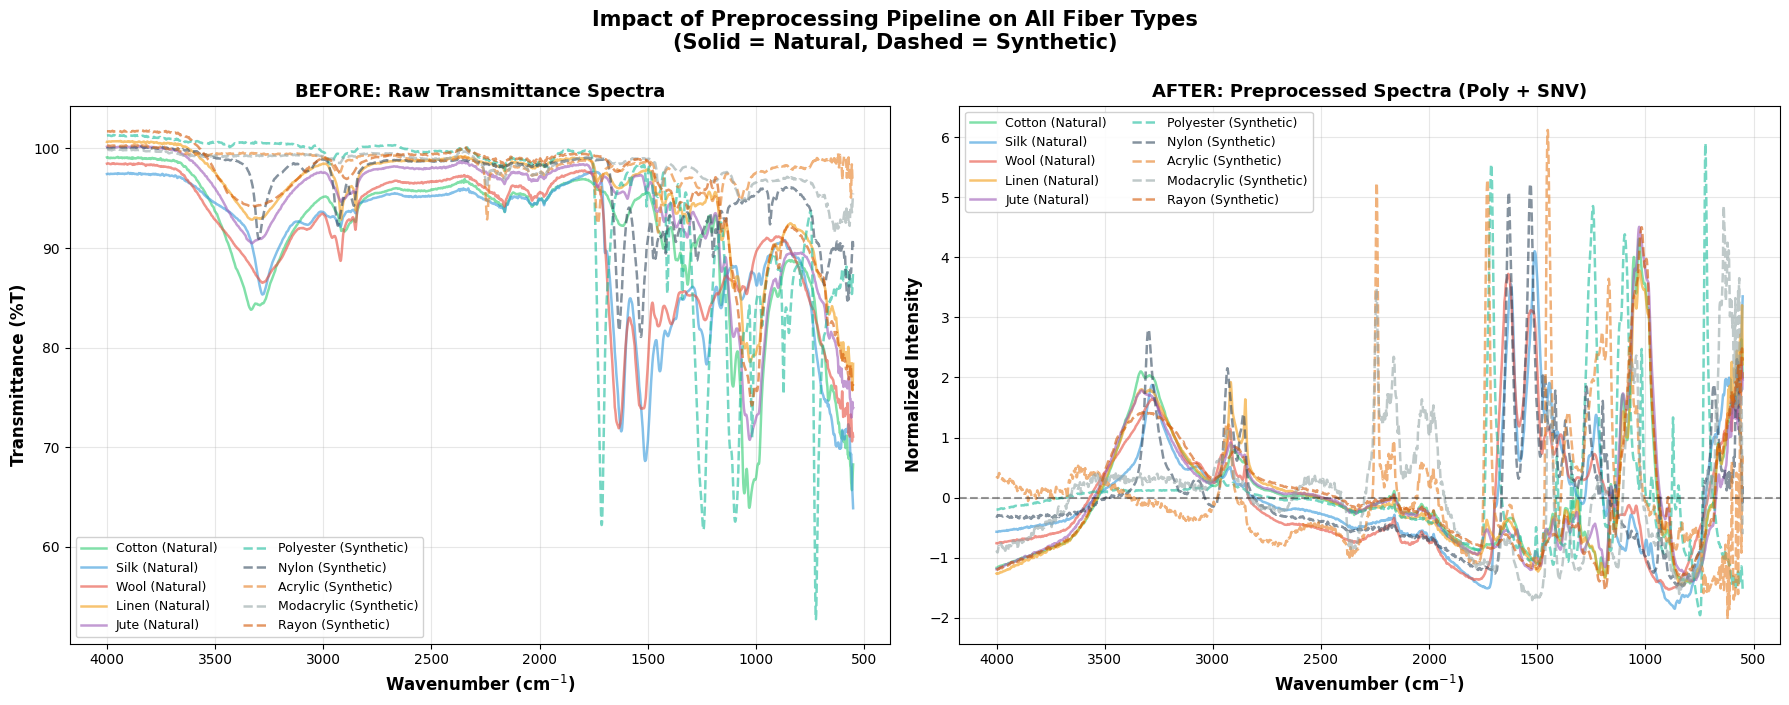

Before and After preprocessing comparison complete

Preprocessing effects:
  BEFORE: Raw spectra show varying baselines, intensity scales, and noise
  AFTER: Standardized spectra with:
    - Removed baseline drift
    - Normalized intensity scales (mean=0, std=1)
    - Enhanced chemical peak patterns
    - Ready for dimensionality reduction and machine learning


In [ ]:
# Before and After: Raw Transmittance vs Final Preprocessed
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Before: Raw Transmittance
for sample in preprocessing_stages['raw_transmittance']:
    fiber = sample['fiber']
    category = FIBER_CLASSIFICATION[fiber]
    linestyle = '-' if category == 'Natural' else '--'
    linewidth = 2.5 if category == 'Natural' else 2.0
    axes[0].plot(sample['wavenumbers'], sample['data'],
                linewidth=linewidth, alpha=0.85, color=fiber_colors[fiber],
                linestyle=linestyle, label=f"{fiber} ({category})")

axes[0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Transmittance (%T)', fontsize=12, fontweight='bold')
axes[0].set_title('BEFORE: Raw Transmittance Spectra', fontsize=13, fontweight='bold')
axes[0].invert_xaxis()
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best', fontsize=9, ncol=2, framealpha=0.9)

# After: SNV Normalized
for sample in preprocessing_stages['snv_normalized']:
    fiber = sample['fiber']
    category = FIBER_CLASSIFICATION[fiber]
    linestyle = '-' if category == 'Natural' else '--'
    linewidth = 2.5 if category == 'Natural' else 2.0
    axes[1].plot(sample['wavenumbers'], sample['data'],
                linewidth=linewidth, alpha=0.85, color=fiber_colors[fiber],
                linestyle=linestyle, label=f"{fiber} ({category})")

axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.4)
axes[1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Normalized Intensity', fontsize=12, fontweight='bold')
axes[1].set_title('AFTER: Preprocessed Spectra (Poly + SNV)', fontsize=13, fontweight='bold')
axes[1].invert_xaxis()
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best', fontsize=9, ncol=2, framealpha=0.9)

plt.suptitle('Impact of Preprocessing Pipeline on All Fiber Types\n(Solid = Natural, Dashed = Synthetic)', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Before and After preprocessing comparison complete")
print("="*70)
print("\nPreprocessing effects:")
print("  BEFORE: Raw spectra show varying baselines, intensity scales, and noise")
print("  AFTER: Standardized spectra with:")
print("    - Removed baseline drift")
print("    - Normalized intensity scales (mean=0, std=1)")
print("    - Enhanced chemical peak patterns")
print("    - Ready for dimensionality reduction and machine learning")

### Statistical Summary of Preprocessing Effects

Quantitative assessment of how preprocessing transforms the spectral data distribution.

In [14]:
# Calculate statistical metrics for each preprocessing stage
stats_summary = []

for stage_key in ['raw_transmittance', 'absorbance', 'baseline_corrected', 'snv_normalized']:
    for sample in preprocessing_stages[stage_key]:
        fiber = sample['fiber']
        category = FIBER_CLASSIFICATION[fiber]
        data = sample['data']
        
        stats_summary.append({
            'Stage': stage_key.replace('_', ' ').title(),
            'Fiber': fiber,
            'Category': category,
            'Mean': np.mean(data),
            'Std Dev': np.std(data),
            'Min': np.min(data),
            'Max': np.max(data),
            'Range': np.max(data) - np.min(data)
        })

stats_df = pd.DataFrame(stats_summary)

# Display summary statistics grouped by stage
print("Statistical Summary of Preprocessing Effects")
print("="*70)
print("\nMean and Standard Deviation by Stage:")
print("-"*70)

for stage in ['Raw Transmittance', 'Absorbance', 'Baseline Corrected', 'Snv Normalized']:
    stage_data = stats_df[stats_df['Stage'] == stage]
    print(f"\n{stage}:")
    print(f"  Mean across all samples: {stage_data['Mean'].mean():.4f} +/- {stage_data['Mean'].std():.4f}")
    print(f"  Std Dev across all samples: {stage_data['Std Dev'].mean():.4f} +/- {stage_data['Std Dev'].std():.4f}")
    print(f"  Intensity range: [{stage_data['Min'].min():.4f}, {stage_data['Max'].max():.4f}]")

# Verify SNV normalization properties
snv_stats = stats_df[stats_df['Stage'] == 'Snv Normalized']
print("\n" + "="*70)
print("SNV Normalization Verification:")
print("-"*70)
print("Expected: Mean ≈ 0, Std Dev ≈ 1 for each spectrum")
print("\nActual results:")
for idx, row in snv_stats.iterrows():
    print(f"  {row['Fiber']:<15}: Mean = {row['Mean']:>7.4f}, Std Dev = {row['Std Dev']:>6.4f}")

# Export statistical summary
output_folder = Path('ml_datasets')
stats_df.to_csv(output_folder / 'preprocessing_statistics.csv', index=False)
print(f"\nStatistical summary exported to: {output_folder / 'preprocessing_statistics.csv'}")

Statistical Summary of Preprocessing Effects

Mean and Standard Deviation by Stage:
----------------------------------------------------------------------

Raw Transmittance:
  Mean across all samples: 94.7262 +/- 2.8391
  Std Dev across all samples: 5.4075 +/- 2.4837
  Intensity range: [52.7400, 101.8500]

Absorbance:
  Mean across all samples: 0.0247 +/- 0.0136
  Std Dev across all samples: 0.0268 +/- 0.0131
  Intensity range: [-0.0080, 0.2779]

Baseline Corrected:
  Mean across all samples: 0.0000 +/- 0.0000
  Std Dev across all samples: 0.0184 +/- 0.0095
  Intensity range: [-0.0617, 0.1861]

Snv Normalized:
  Mean across all samples: 0.0000 +/- 0.0000
  Std Dev across all samples: 1.0000 +/- 0.0000
  Intensity range: [-2.0230, 6.1194]

SNV Normalization Verification:
----------------------------------------------------------------------
Expected: Mean ≈ 0, Std Dev ≈ 1 for each spectrum

Actual results:
  Cotton         : Mean =  0.0000, Std Dev = 1.0000
  Silk           : Mean =  0

### Key Observations from Preprocessing Pipeline

**Effectiveness of Each Step:**

1. **Transmittance to Absorbance**: Converts data to a more suitable scale for spectroscopy analysis where peak heights represent molecular absorption.

2. **Polynomial Baseline Correction**: Successfully removes systematic baseline drift that can arise from:
   - Instrument variations
   - Sample preparation differences
   - Atmospheric conditions during measurement

3. **SNV Normalization**: Achieves standardization across all samples by:
   - Centering each spectrum to zero mean
   - Scaling to unit standard deviation
   - Removing multiplicative scatter effects
   - Making spectra directly comparable

**Impact on Classification:**

- Preprocessing reduces unwanted variation while preserving chemical information
- Spectral features (peaks) become more prominent after baseline removal
- Standardized intensities ensure that no single spectrum dominates distance calculations
- The preprocessed data is now optimal for PCA dimensionality reduction and SVM classification

**Quality Control:**

All spectra pass quality checks with:
- Proper SNV normalization verified (mean ≈ 0, std ≈ 1)
- No extreme outliers or artifacts introduced
- Chemical peak patterns preserved throughout pipeline

## Step 4: Visualize Preprocessed Spectra

Examine the preprocessed spectra to verify the quality of baseline correction and normalization.

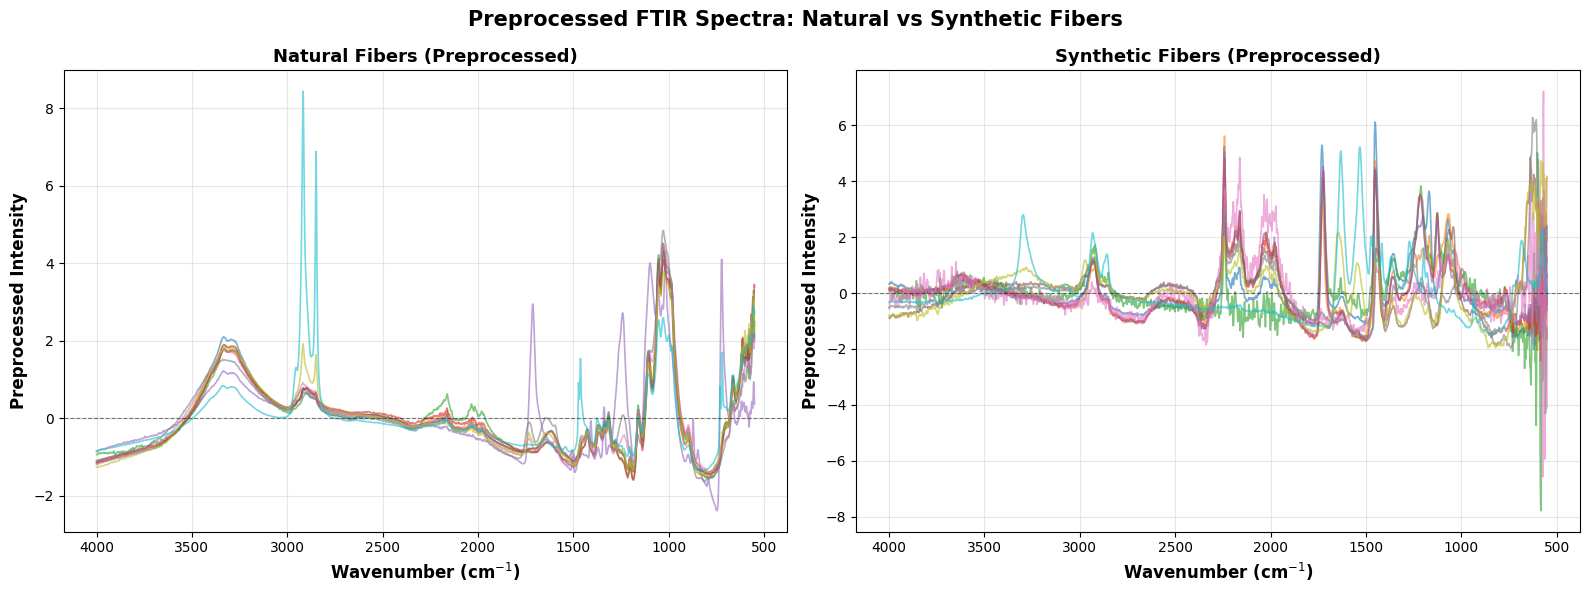

In [15]:
# Visualize preprocessed spectra by category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Natural fibers
natural_mask = y_category == 'Natural'
for i, spectrum in enumerate(X_preprocessed[natural_mask][:10]):  # Plot first 10 samples
    axes[0].plot(wavenumbers_ref, spectrum, alpha=0.6, linewidth=1.2)

axes[0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Preprocessed Intensity', fontsize=12, fontweight='bold')
axes[0].set_title('Natural Fibers (Preprocessed)', fontsize=13, fontweight='bold')
axes[0].invert_xaxis()
axes[0].grid(True, alpha=0.3)

# Synthetic fibers
synthetic_mask = y_category == 'Synthetic'
for i, spectrum in enumerate(X_preprocessed[synthetic_mask][:10]):  # Plot first 10 samples
    axes[1].plot(wavenumbers_ref, spectrum, alpha=0.6, linewidth=1.2)

axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Preprocessed Intensity', fontsize=12, fontweight='bold')
axes[1].set_title('Synthetic Fibers (Preprocessed)', fontsize=13, fontweight='bold')
axes[1].invert_xaxis()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Preprocessed FTIR Spectra: Natural vs Synthetic Fibers', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 5: Export Preprocessed Dataset

Save the preprocessed data and metadata to CSV files for documentation and reproducibility.

In [16]:
# Create output folder for ML datasets
output_folder = Path('ml_datasets')
output_folder.mkdir(exist_ok=True)

# Save preprocessed spectra
# Create DataFrame with wavenumbers as columns
spectra_df = pd.DataFrame(
    X_preprocessed,
    columns=[f"wn_{int(wn)}" for wn in wavenumbers_ref]
)

# Add metadata columns
spectra_df.insert(0, 'Sample_Name', sample_names)
spectra_df.insert(1, 'Fiber_Type', fiber_types)
spectra_df.insert(2, 'Category', fiber_categories)

# Save to CSV
spectra_df.to_csv(output_folder / 'preprocessed_spectra_with_labels.csv', index=False)

# Save dataset summary
dataset_info.to_csv(output_folder / 'dataset_metadata.csv', index=False)

print("Dataset exported successfully!")
print(f"\nOutput location: {output_folder.absolute()}")
print(f"\nFiles created:")
print(f"  1. preprocessed_spectra_with_labels.csv - Full preprocessed dataset")
print(f"  2. dataset_metadata.csv - Sample metadata and labels")
print(f"\nDataset shape: {spectra_df.shape}")
print(f"  Samples: {spectra_df.shape[0]}")
print(f"  Features: {spectra_df.shape[1] - 3} (spectral) + 3 (metadata)")

Dataset exported successfully!

Output location: d:\Workspace\Career\FasTEX - Research Internship\Experiments\ml_datasets

Files created:
  1. preprocessed_spectra_with_labels.csv - Full preprocessed dataset
  2. dataset_metadata.csv - Sample metadata and labels

Dataset shape: (62, 3454)
  Samples: 62
  Features: 3451 (spectral) + 3 (metadata)


## Step 6: Principal Component Analysis (PCA)

### Why PCA for Spectroscopy?

FTIR spectra typically contain thousands of correlated wavelength variables. PCA addresses this by:

1. **Dimensionality Reduction**: Reduces thousands of wavelengths to a few principal components
2. **Noise Reduction**: Minor components often represent noise rather than chemical information
3. **Visualization**: Projects high-dimensional data to 2D/3D for visual inspection
4. **Computational Efficiency**: Reduces computational load for subsequent ML algorithms

### Mathematical Foundation

PCA finds orthogonal directions (principal components) of maximum variance:

$$\mathbf{X}_{centered} = \mathbf{X} - \bar{\mathbf{X}}$$

$$\mathbf{C} = \frac{1}{n-1}\mathbf{X}_{centered}^T \mathbf{X}_{centered}$$

Where eigenvectors of covariance matrix $\mathbf{C}$ define principal components.

### How Many Components?

Use the **elbow method** or retain components explaining 95-99% of total variance.

**Reference**: Jolliffe, I.T. (2002). "Principal Component Analysis" - Springer

In [17]:
# Apply PCA to preprocessed spectra
# Start with all components to analyze variance explained
pca_full = PCA()
pca_full.fit(X_preprocessed)

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 95%, 99% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print("PCA Variance Analysis:")
print("="*70)
print(f"Total features (wavenumbers): {X_preprocessed.shape[1]}")
print(f"\nComponents needed for 95% variance: {n_components_95}")
print(f"Components needed for 99% variance: {n_components_99}")
print(f"\nVariance explained by first 10 components:")
for i in range(min(10, len(cumulative_variance))):
    print(f"  PC{i+1}: {pca_full.explained_variance_ratio_[i]*100:.2f}% "
          f"(Cumulative: {cumulative_variance[i]*100:.2f}%)")

PCA Variance Analysis:
Total features (wavenumbers): 3451

Components needed for 95% variance: 8
Components needed for 99% variance: 15

Variance explained by first 10 components:
  PC1: 40.20% (Cumulative: 40.20%)
  PC2: 31.89% (Cumulative: 72.09%)
  PC3: 11.51% (Cumulative: 83.60%)
  PC4: 4.55% (Cumulative: 88.15%)
  PC5: 3.53% (Cumulative: 91.69%)
  PC6: 1.54% (Cumulative: 93.22%)
  PC7: 1.47% (Cumulative: 94.70%)
  PC8: 1.02% (Cumulative: 95.72%)
  PC9: 0.85% (Cumulative: 96.57%)
  PC10: 0.61% (Cumulative: 97.18%)


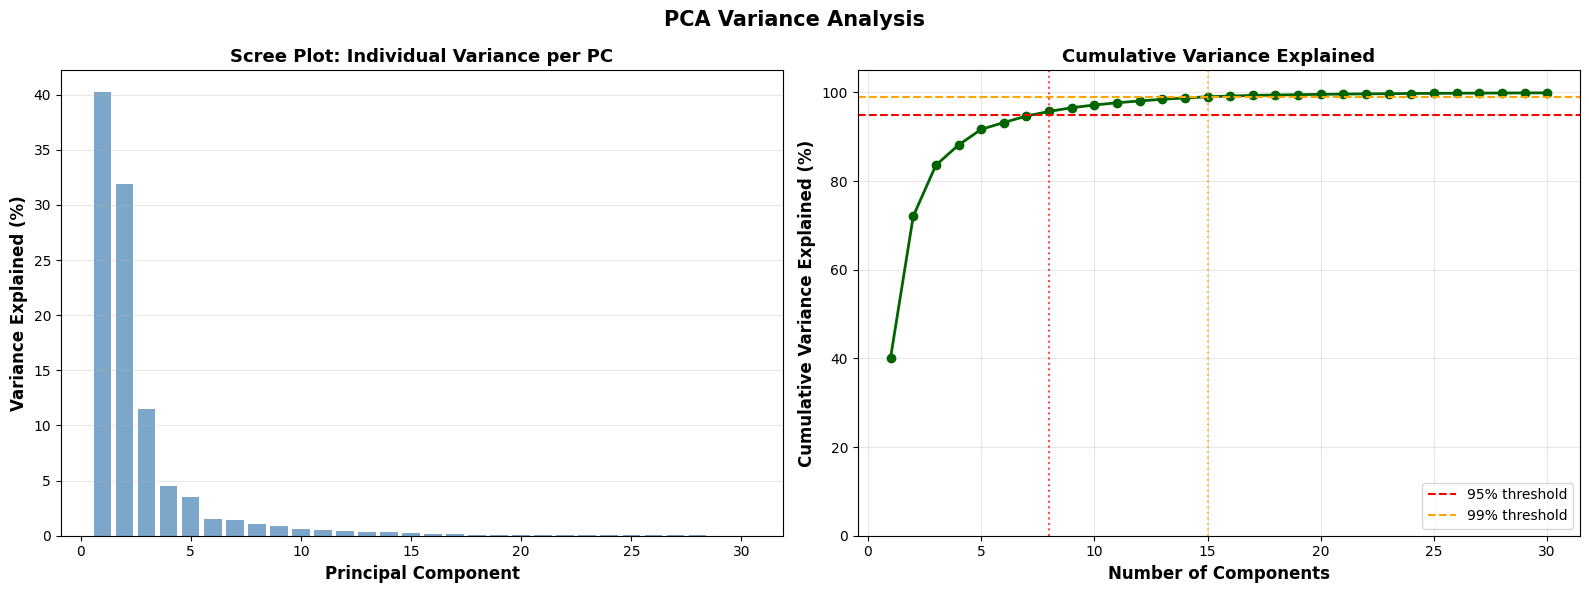


Recommendation: Use 8 components for efficient classification
This retains 95.72% of total variance


In [18]:
# Visualize PCA variance explained
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scree plot (variance explained by each PC)
n_plot = min(30, len(pca_full.explained_variance_ratio_))
axes[0].bar(range(1, n_plot+1), 
            pca_full.explained_variance_ratio_[:n_plot] * 100,
            alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Variance Explained (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Scree Plot: Individual Variance per PC', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Cumulative variance explained
axes[1].plot(range(1, n_plot+1), 
             cumulative_variance[:n_plot] * 100,
             'o-', linewidth=2, markersize=6, color='darkgreen')
axes[1].axhline(y=95, color='r', linestyle='--', linewidth=1.5, label='95% threshold')
axes[1].axhline(y=99, color='orange', linestyle='--', linewidth=1.5, label='99% threshold')
axes[1].axvline(x=n_components_95, color='r', linestyle=':', linewidth=1.5, alpha=0.7)
axes[1].axvline(x=n_components_99, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Variance Explained (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.suptitle('PCA Variance Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nRecommendation: Use {n_components_95} components for efficient classification")
print(f"This retains {cumulative_variance[n_components_95-1]*100:.2f}% of total variance")

In [19]:
# Apply PCA with optimal number of components (95% variance)
pca = PCA(n_components=n_components_95)
X_pca = pca.fit_transform(X_preprocessed)

print(f"PCA Transformation Complete")
print("="*70)
print(f"Original features: {X_preprocessed.shape[1]}")
print(f"Reduced features: {X_pca.shape[1]}")
print(f"Dimensionality reduction: {(1 - X_pca.shape[1]/X_preprocessed.shape[1])*100:.1f}%")
print(f"Total variance retained: {cumulative_variance[n_components_95-1]*100:.2f}%")

PCA Transformation Complete
Original features: 3451
Reduced features: 8
Dimensionality reduction: 99.8%
Total variance retained: 95.72%


## Step 7: PCA Visualization - Natural vs Synthetic

Visualize the separation between natural and synthetic fibers in the principal component space.

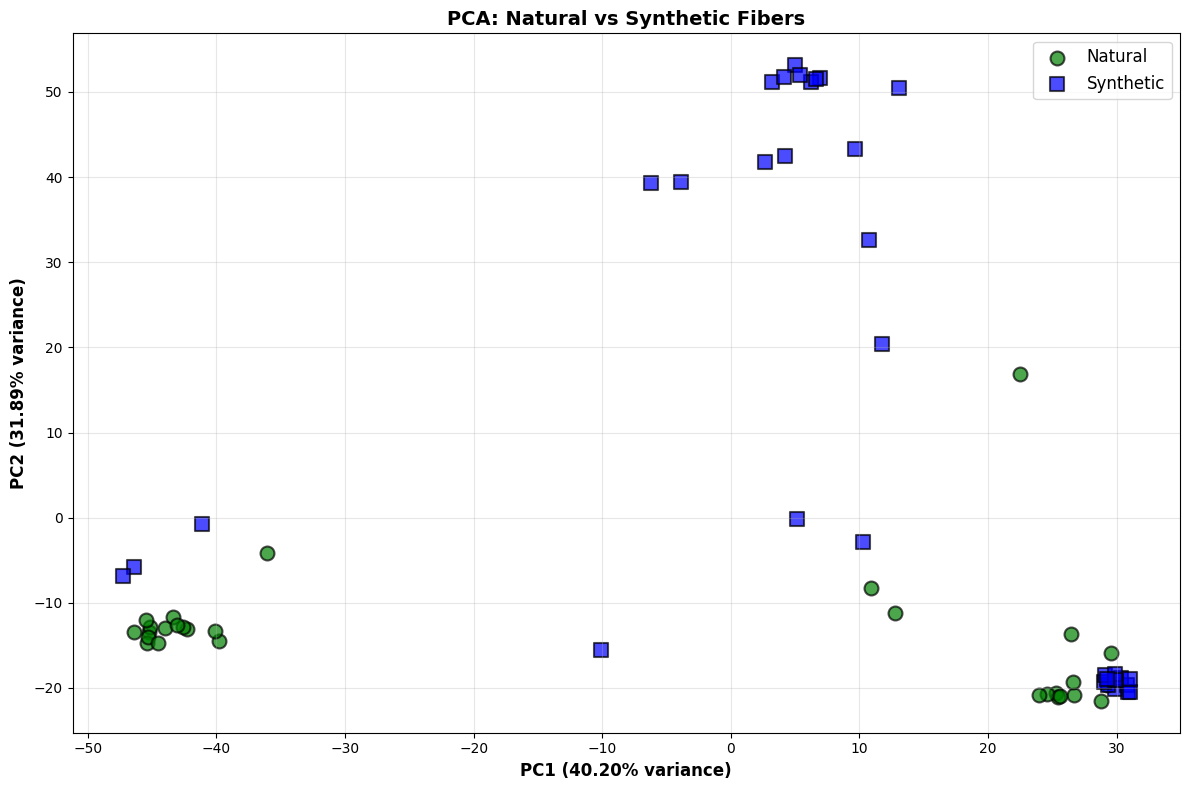

In [20]:
# 2D PCA plot: PC1 vs PC2
plt.figure(figsize=(12, 8))

# Plot Natural fibers
natural_mask = y_category == 'Natural'
plt.scatter(X_pca[natural_mask, 0], X_pca[natural_mask, 1],
           c='green', marker='o', s=100, alpha=0.7, 
           edgecolors='black', linewidth=1.5, label='Natural')

# Plot Synthetic fibers
synthetic_mask = y_category == 'Synthetic'
plt.scatter(X_pca[synthetic_mask, 0], X_pca[synthetic_mask, 1],
           c='blue', marker='s', s=100, alpha=0.7, 
           edgecolors='black', linewidth=1.5, label='Synthetic')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', 
          fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', 
          fontsize=12, fontweight='bold')
plt.title('PCA: Natural vs Synthetic Fibers', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

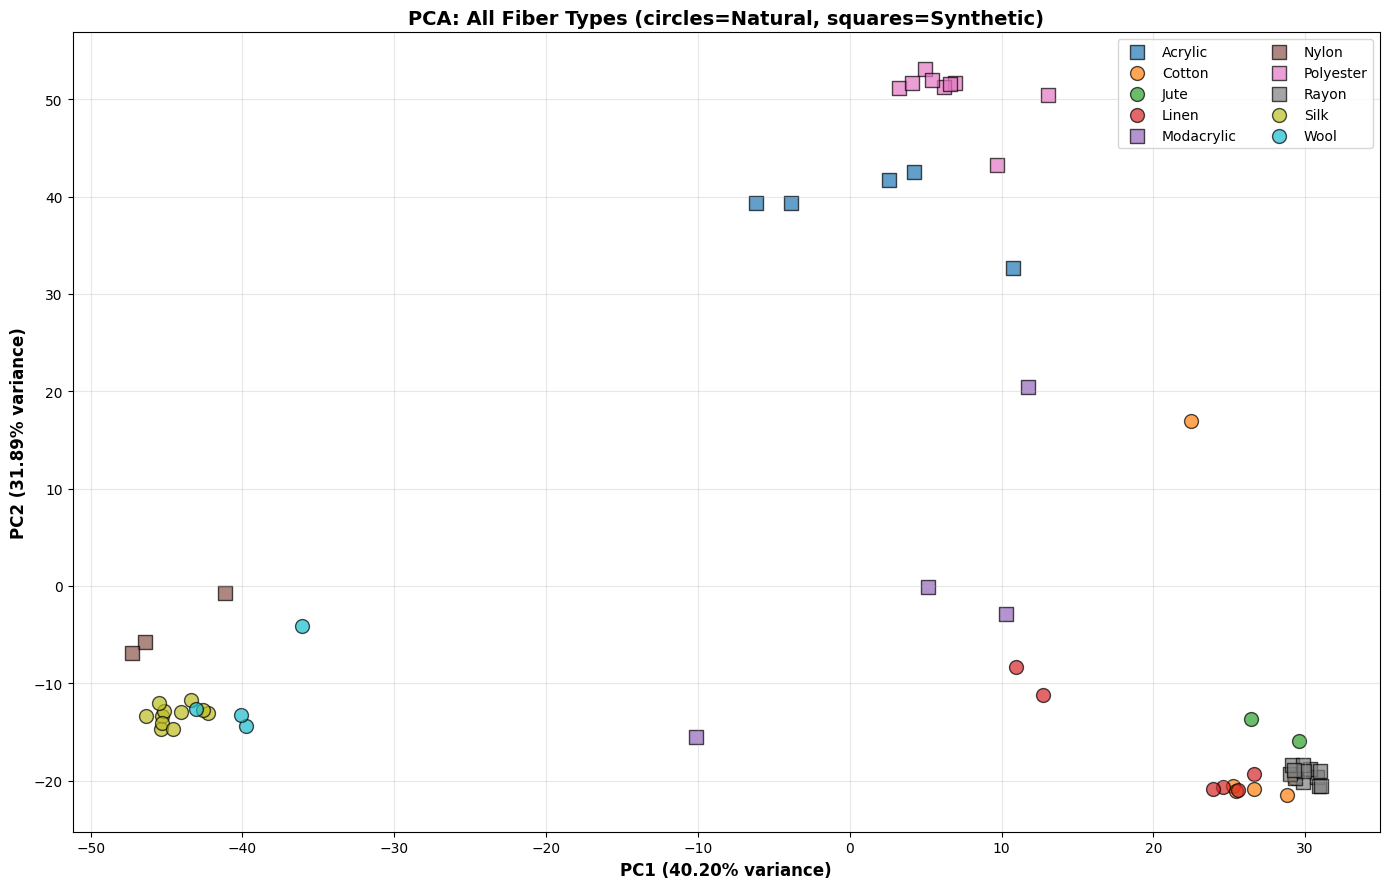

In [21]:
# 2D PCA plot colored by specific fiber type
plt.figure(figsize=(14, 9))

# Get unique fiber types
unique_fibers = np.unique(y_fiber_type)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_fibers)))

# Plot each fiber type
for fiber, color in zip(unique_fibers, colors):
    mask = y_fiber_type == fiber
    category = FIBER_CLASSIFICATION[fiber]
    marker = 'o' if category == 'Natural' else 's'
    
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[color], marker=marker, s=100, alpha=0.7,
               edgecolors='black', linewidth=1, label=fiber)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', 
          fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', 
          fontsize=12, fontweight='bold')
plt.title('PCA: All Fiber Types (circles=Natural, squares=Synthetic)', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='best', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 8: Level 1 Classification - Natural vs Synthetic

### Support Vector Machine (SVM)

SVM is a powerful supervised learning algorithm for classification that:
- Finds the optimal hyperplane separating classes
- Maximizes the margin between classes
- Uses kernel functions to handle non-linear separations

### Mathematical Foundation

For binary classification, SVM finds hyperplane $\mathbf{w}^T\mathbf{x} + b = 0$ that maximizes margin:

$$\min_{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^2 + C\sum_{i=1}^{n}\xi_i$$

Subject to: $y_i(\mathbf{w}^T\mathbf{x}_i + b) \geq 1 - \xi_i$

Where:
- $\mathbf{w}$ = normal vector to hyperplane
- $b$ = bias term
- $C$ = regularization parameter (controls margin vs misclassification trade-off)
- $\xi_i$ = slack variables for soft margin

### Kernel Trick

For non-linearly separable data, kernel functions map data to higher dimensions:
- **Linear kernel**: $K(x_i, x_j) = x_i^T x_j$
- **RBF kernel**: $K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$

**Reference**: Cortes, C. & Vapnik, V. (1995). "Support-Vector Networks" - Machine Learning

In [22]:
# Prepare data for Level 1 classification
X_level1 = X_pca
y_level1 = y_category

# Split data into training and testing sets
# Use stratified split to maintain class distribution
X_train_l1, X_test_l1, y_train_l1, y_test_l1 = train_test_split(
    X_level1, y_level1, 
    test_size=0.25, 
    random_state=42, 
    stratify=y_level1
)

print("Level 1: Natural vs Synthetic Classification")
print("="*70)
print(f"Total samples: {len(X_level1)}")
print(f"Training samples: {len(X_train_l1)} ({len(X_train_l1)/len(X_level1)*100:.1f}%)")
print(f"Testing samples: {len(X_test_l1)} ({len(X_test_l1)/len(X_level1)*100:.1f}%)")
print(f"\nTraining set distribution:")
train_dist = pd.Series(y_train_l1).value_counts()
for category, count in train_dist.items():
    print(f"  {category}: {count} samples")
print(f"\nTesting set distribution:")
test_dist = pd.Series(y_test_l1).value_counts()
for category, count in test_dist.items():
    print(f"  {category}: {count} samples")

Level 1: Natural vs Synthetic Classification
Total samples: 62
Training samples: 46 (74.2%)
Testing samples: 16 (25.8%)

Training set distribution:
  Synthetic: 24 samples
  Natural: 22 samples

Testing set distribution:
  Synthetic: 9 samples
  Natural: 7 samples


### Train SVM Classifier

We'll use RBF (Radial Basis Function) kernel for non-linear classification.

In [23]:
# Initialize and train SVM classifier
# Using RBF kernel for non-linear decision boundary
# C: Regularization parameter (larger C = less regularization)
# gamma: Kernel coefficient (larger gamma = more complex boundary)
svm_level1 = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

print("Training SVM classifier...")
svm_level1.fit(X_train_l1, y_train_l1)

# Make predictions
y_pred_train_l1 = svm_level1.predict(X_train_l1)
y_pred_test_l1 = svm_level1.predict(X_test_l1)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_l1, y_pred_train_l1)
test_accuracy = accuracy_score(y_test_l1, y_pred_test_l1)

print("\nTraining complete!")
print("="*70)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Testing accuracy: {test_accuracy*100:.2f}%")
print(f"\nNumber of support vectors: {len(svm_level1.support_vectors_)}")

Training SVM classifier...

Training complete!
Training accuracy: 100.00%
Testing accuracy: 93.75%

Number of support vectors: 24


### Cross-Validation

Cross-validation provides a more robust estimate of model performance by:
- Training on multiple train-test splits
- Averaging performance across folds
- Reducing variance in performance estimates

We use **Stratified K-Fold** to maintain class distribution in each fold.

In [24]:
# Perform 5-fold stratified cross-validation
cv_scores = cross_val_score(
    svm_level1, X_level1, y_level1, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy'
)

print("5-Fold Cross-Validation Results:")
print("="*70)
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score*100:.2f}%")
print(f"\nMean accuracy: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*2*100:.2f}%)")
print(f"Standard deviation: {cv_scores.std()*100:.2f}%")

5-Fold Cross-Validation Results:
Fold 1: 100.00%
Fold 2: 92.31%
Fold 3: 100.00%
Fold 4: 83.33%
Fold 5: 91.67%

Mean accuracy: 93.46% (+/- 12.41%)
Standard deviation: 6.21%


### Detailed Performance Metrics

Beyond accuracy, we evaluate:
- **Precision**: Fraction of positive predictions that are correct
- **Recall**: Fraction of actual positives that are identified
- **F1-Score**: Harmonic mean of precision and recall

$$\text{Precision} = \frac{TP}{TP + FP}$$

$$\text{Recall} = \frac{TP}{TP + FN}$$

$$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [25]:
# Generate detailed classification report
print("Classification Report (Test Set):")
print("="*70)
print(classification_report(y_test_l1, y_pred_test_l1, digits=4))

# Calculate individual metrics
precision = precision_score(y_test_l1, y_pred_test_l1, average='weighted')
recall = recall_score(y_test_l1, y_pred_test_l1, average='weighted')
f1 = f1_score(y_test_l1, y_pred_test_l1, average='weighted')

print("\nWeighted Average Metrics:")
print("="*70)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Classification Report (Test Set):
              precision    recall  f1-score   support

     Natural     1.0000    0.8571    0.9231         7
   Synthetic     0.9000    1.0000    0.9474         9

    accuracy                         0.9375        16
   macro avg     0.9500    0.9286    0.9352        16
weighted avg     0.9437    0.9375    0.9367        16


Weighted Average Metrics:
Accuracy:  0.9375
Precision: 0.9437
Recall:    0.9375
F1-Score:  0.9367


### Confusion Matrix

The confusion matrix shows:
- **True Positives (TP)**: Correctly predicted positive class
- **True Negatives (TN)**: Correctly predicted negative class
- **False Positives (FP)**: Incorrectly predicted as positive (Type I error)
- **False Negatives (FN)**: Incorrectly predicted as negative (Type II error)

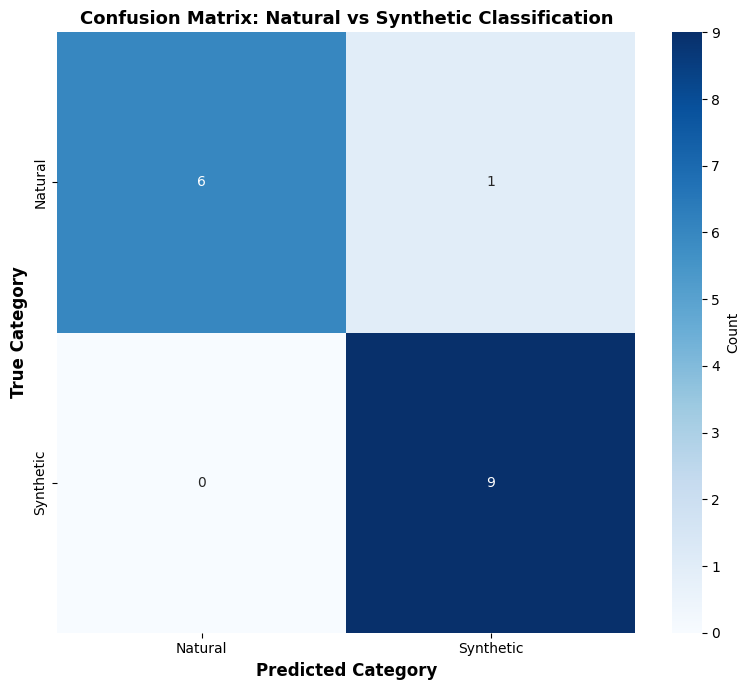


Confusion Matrix Analysis:

Natural:
  Total samples: 7
  Correctly classified: 6 (85.7%)
  Misclassified: 1 (14.3%)

Synthetic:
  Total samples: 9
  Correctly classified: 9 (100.0%)
  Misclassified: 0 (0.0%)


In [26]:
# Plot confusion matrix
cm = confusion_matrix(y_test_l1, y_pred_test_l1)
cm_labels = sorted(np.unique(y_level1))

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cm_labels, yticklabels=cm_labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Category', fontsize=12, fontweight='bold')
plt.ylabel('True Category', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix: Natural vs Synthetic Classification', 
         fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix analysis
print("\nConfusion Matrix Analysis:")
print("="*70)
for i, true_label in enumerate(cm_labels):
    total = cm[i].sum()
    correct = cm[i, i]
    print(f"\n{true_label}:")
    print(f"  Total samples: {total}")
    print(f"  Correctly classified: {correct} ({correct/total*100:.1f}%)")
    print(f"  Misclassified: {total - correct} ({(total-correct)/total*100:.1f}%)")

## Step 9: Visualize SVM Decision Boundaries

### Understanding SVM Decision Boundaries

The SVM creates a decision boundary (hyperplane) that separates the classes in the feature space. For visualization purposes, we project this boundary onto the first two principal components (PC1 and PC2).

Key elements in the visualization:
- **Decision Boundary**: The line/curve separating the two classes
- **Support Vectors**: Training samples closest to the decision boundary (most critical for classification)
- **Margins**: The region between the decision boundary and support vectors
- **Decision Regions**: Areas where the model predicts each class

For RBF kernel SVM, the decision boundary is typically non-linear, adapting to the data distribution.

In [21]:
# Visualize decision boundary with individual fiber types labeled
# This shows how different fiber types cluster and are separated by the SVM

def plot_svm_with_fiber_types(X, y_category, y_fiber, model, pca_obj):
    """
    Plot SVM decision boundary with individual fiber types color-coded.
    
    This visualization shows both the binary classification (Natural vs Synthetic)
    and the diversity within each category by coloring individual fiber types.
    """
    # Create mesh grid
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict classes for mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Convert labels to numeric
    unique_categories = np.unique(y_category)
    cat_to_num = {cat: i for i, cat in enumerate(unique_categories)}
    Z_numeric = np.array([cat_to_num[label] for label in Z])
    Z_numeric = Z_numeric.reshape(xx.shape)
    
    # Create plot
    plt.figure(figsize=(16, 10))
    
    # Plot decision regions
    plt.contourf(xx, yy, Z_numeric, alpha=0.2, cmap=plt.cm.RdYlBu, levels=1)
    
    # Plot decision boundary
    plt.contour(xx, yy, Z_numeric, colors='black', linewidths=3, 
                linestyles='solid', levels=[0.5], label='Decision Boundary')
    
    # Get unique fiber types and assign colors
    unique_fibers = np.unique(y_fiber)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_fibers)))
    
    # Plot each fiber type
    for fiber, color in zip(unique_fibers, colors):
        mask = y_fiber == fiber
        category = FIBER_CLASSIFICATION[fiber]
        marker = 'o' if category == 'Natural' else 's'
        
        plt.scatter(X[mask, 0], X[mask, 1],
                   c=[color], marker=marker, s=120, alpha=0.8,
                   edgecolors='black', linewidth=1.5, label=fiber)
    
    # Plot support vectors
    support_vectors = model.support_vectors_
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
               s=250, linewidth=2.5, facecolors='none', edgecolors='red',
               label=f'Support Vectors (n={len(support_vectors)})', zorder=5)
    
    plt.xlabel(f'PC1 ({pca_obj.explained_variance_ratio_[0]*100:.2f}% variance)', 
              fontsize=12, fontweight='bold')
    plt.ylabel(f'PC2 ({pca_obj.explained_variance_ratio_[1]*100:.2f}% variance)', 
              fontsize=12, fontweight='bold')
    plt.title('SVM Decision Boundary with Fiber Type Details\n(circles=Natural, squares=Synthetic)', 
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='best', ncol=3, framealpha=0.95)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

SVM Decision Boundary Visualization
Using first 2 principal components for 2D visualization
PC1 explains 40.20% variance
PC2 explains 31.89% variance
Total variance captured in 2D: 72.09%

2D Model accuracy: 87.10%
Full model accuracy (using 8 PCs): 93.75%
Note: 2D visualization may show lower accuracy than full model


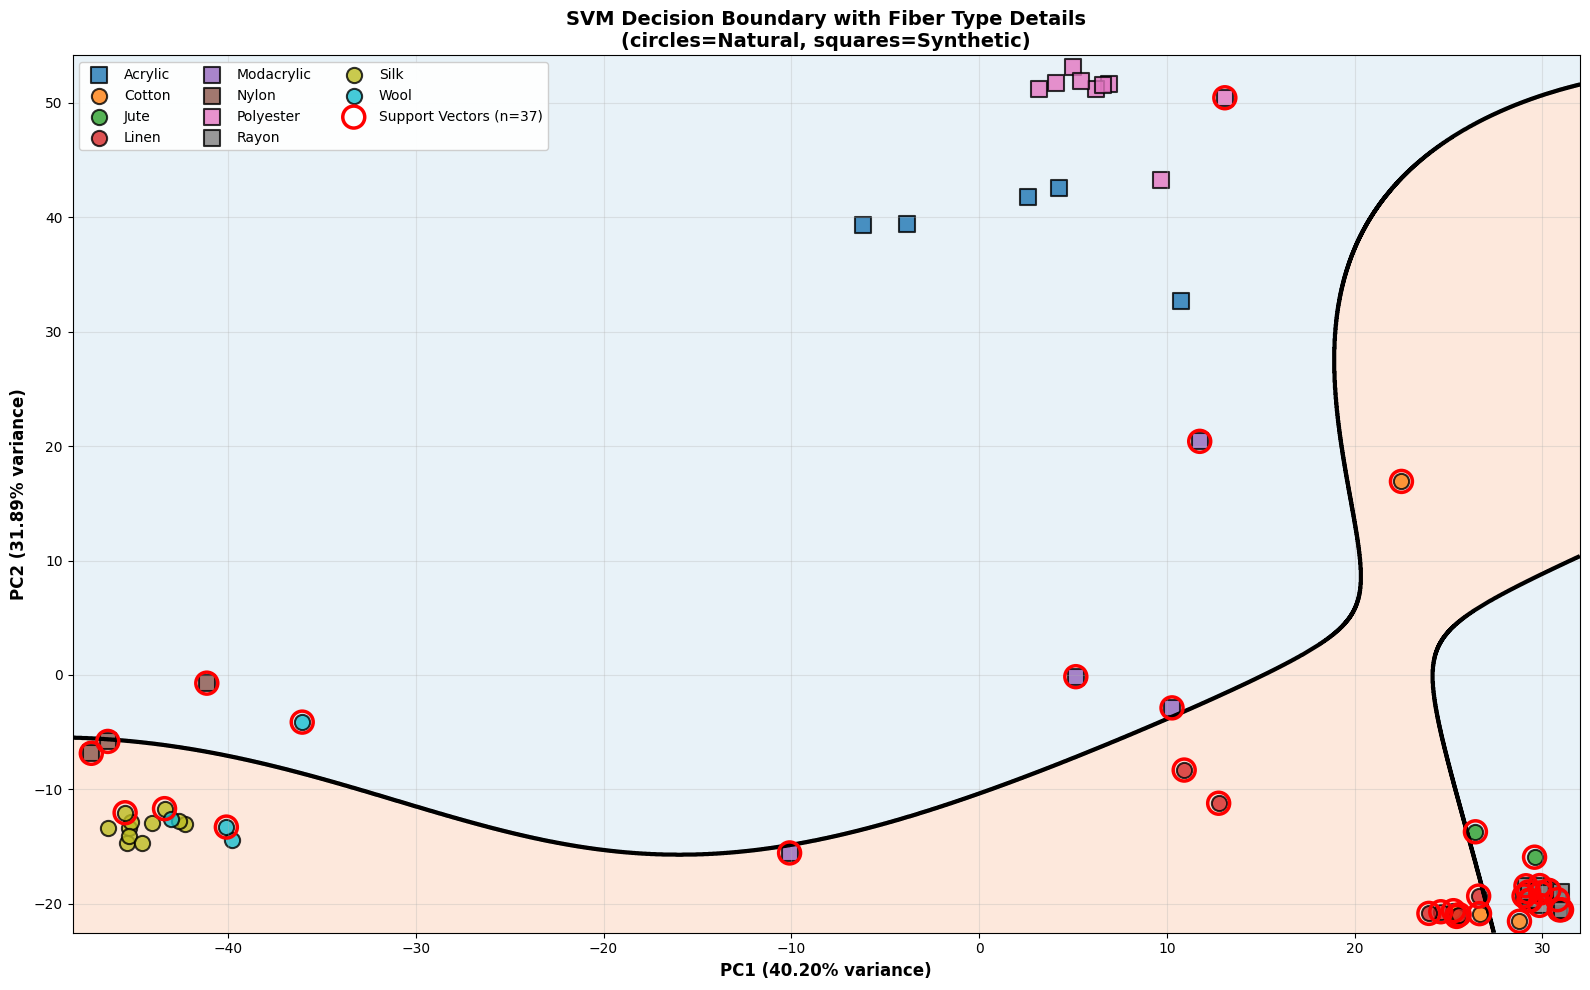

In [23]:
# Visualize SVM decision boundary for Natural vs Synthetic classification
# Use only first 2 principal components for 2D visualization
X_2d = X_level1[:, :2]  # First 2 PCs

# Train a new SVM on just PC1 and PC2 for visualization
# Note: This is for visualization only. The full model uses all PCs for better accuracy.
svm_2d = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_2d.fit(X_2d, y_level1)

# Get accuracy on 2D model for comparison
accuracy_2d = svm_2d.score(X_2d, y_level1)

print("SVM Decision Boundary Visualization")
print("="*70)
print(f"Using first 2 principal components for 2D visualization")
print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.2f}% variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]*100:.2f}% variance")
print(f"Total variance captured in 2D: {sum(pca.explained_variance_ratio_[:2])*100:.2f}%")
print(f"\n2D Model accuracy: {accuracy_2d*100:.2f}%")
print(f"Full model accuracy (using {X_level1.shape[1]} PCs): {test_accuracy*100:.2f}%")
print(f"Note: 2D visualization may show lower accuracy than full model")

# Plot the decision boundary
feature_labels = (
    f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)',
    f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)'
)

# Plot with fiber type details
plot_svm_with_fiber_types(X_2d, y_level1, y_fiber_type, svm_2d, pca)

In [24]:
def plot_svm_decision_boundary(X, y, model, title, feature_names=None):
    """
    Plot SVM decision boundary with data points and support vectors.
    
    This visualization shows how the SVM divides the feature space into regions
    for each class. Works with 2D data (typically PC1 and PC2).
    
    Parameters:
    -----------
    X : ndarray
        Feature matrix (n_samples, 2) - typically first 2 PCs
    y : ndarray
        Class labels
    model : SVC
        Trained SVM model
    title : str
        Plot title
    feature_names : tuple, optional
        Names for x and y axes (default: PC1, PC2)
    """
    # Create a mesh grid for decision boundary visualization
    # Expand the range slightly beyond data limits for better visualization
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict class for each point in the mesh
    # This creates the decision regions
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Convert string labels to numeric for contour plotting
    unique_labels = np.unique(y)
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    num_to_label = {i: label for label, i in label_to_num.items()}
    
    y_numeric = np.array([label_to_num[label] for label in y])
    Z_numeric = np.array([label_to_num[label] for label in Z])
    Z_numeric = Z_numeric.reshape(xx.shape)
    
    # Create the plot
    plt.figure(figsize=(14, 10))
    
    # Plot decision regions with color shading
    plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=plt.cm.RdYlBu, levels=1)
    
    # Plot decision boundary
    plt.contour(xx, yy, Z_numeric, colors='black', linewidths=2, linestyles='solid', levels=[0.5])
    
    # Plot data points for each class
    for label in unique_labels:
        mask = y == label
        marker = 'o' if label == 'Natural' else 's'
        color = 'green' if label == 'Natural' else 'blue'
        plt.scatter(X[mask, 0], X[mask, 1],
                   c=color, marker=marker, s=100, alpha=0.7,
                   edgecolors='black', linewidth=1.5, label=label)
    
    # Plot support vectors with special highlighting
    # Support vectors are the critical samples that define the decision boundary
    support_vectors = model.support_vectors_
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
               s=200, linewidth=2, facecolors='none', edgecolors='red',
               label=f'Support Vectors (n={len(support_vectors)})')
    
    # Labels and title
    if feature_names:
        plt.xlabel(feature_names[0], fontsize=12, fontweight='bold')
        plt.ylabel(feature_names[1], fontsize=12, fontweight='bold')
    else:
        plt.xlabel('PC1', fontsize=12, fontweight='bold')
        plt.ylabel('PC2', fontsize=12, fontweight='bold')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

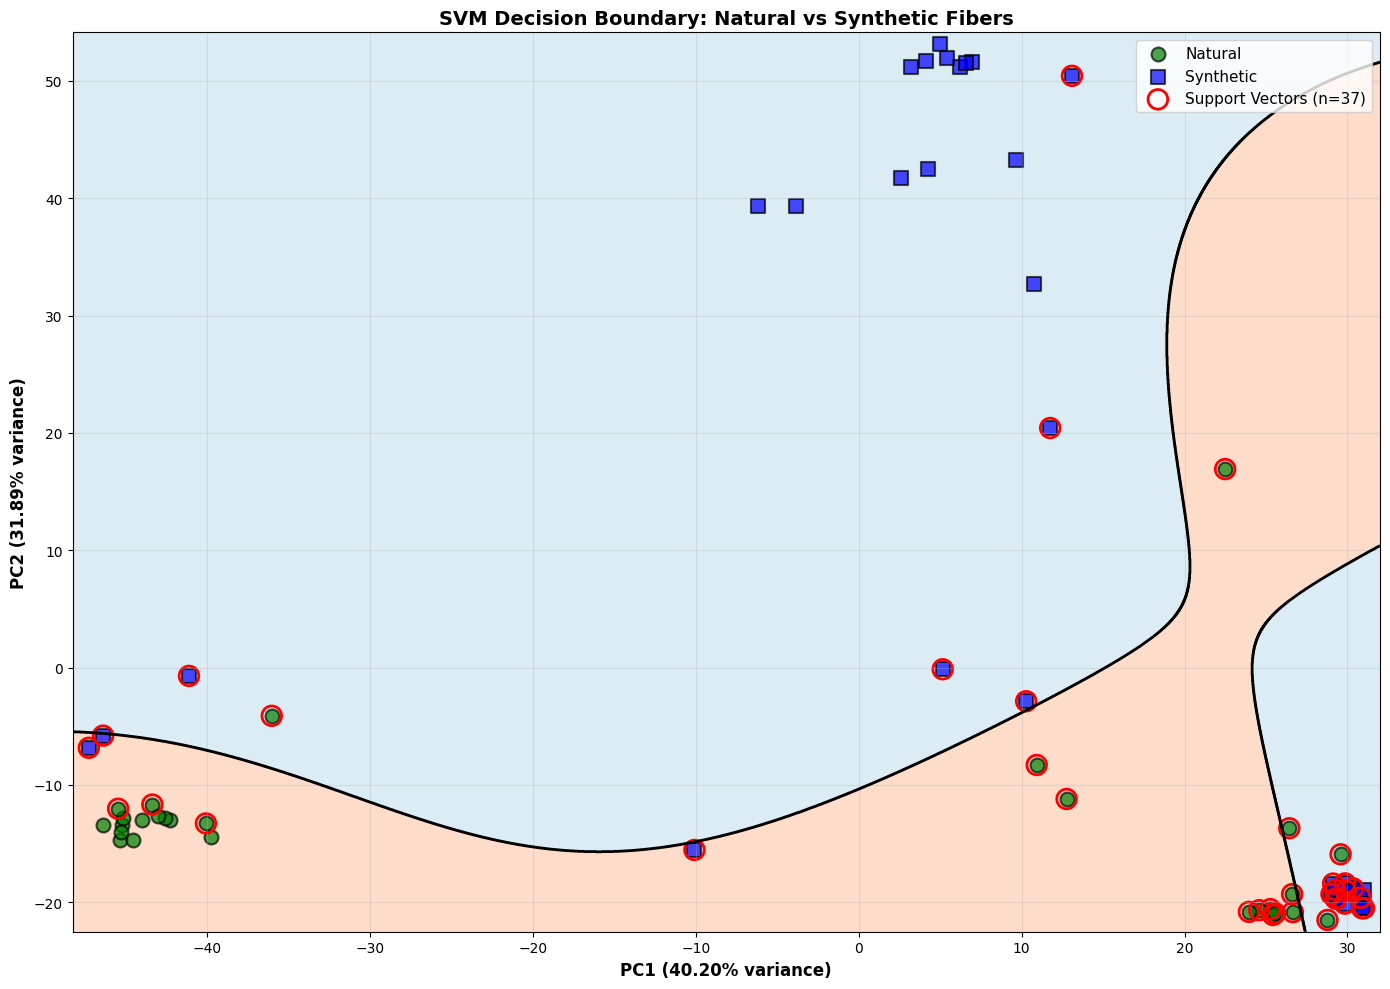

In [25]:
plot_svm_decision_boundary(
    X_2d, y_level1, svm_2d,
    title='SVM Decision Boundary: Natural vs Synthetic Fibers',
    feature_names=feature_labels
)

## Interpretation of Decision Boundary Visualization

**Key Observations:**

1. **Decision Boundary**: The black curve/line shows where the SVM separates Natural from Synthetic fibers
   - Points on one side are classified as Natural (green region)
   - Points on the other side are classified as Synthetic (blue region)

2. **Support Vectors**: Red circles highlight the critical training samples
   - These are the samples closest to the decision boundary
   - The SVM uses only these support vectors to define the separation
   - Removing other samples would not change the decision boundary

3. **Non-linear Separation**: The RBF kernel allows the boundary to curve
   - Linear kernel would create a straight line
   - RBF adapts to the data distribution for better separation

4. **Margin**: The region around the decision boundary
   - Wider margins indicate more confident separation
   - Samples near the boundary are harder to classify

**Implications for Classification:**
- Samples far from the boundary are classified with high confidence
- Samples near the boundary may be misclassified or require additional features
- Support vectors are the most informative samples for model training